# Méthodologie d'entrainement des modèles

L'objectif de notre projet est de prédire, dans un premier temps, le score d'un client donné et à partir de ce score classé le client comme client défaillant ou honnête dans le remboursement d'un prêt. Pour ce faire, nous allons passer par plusieurs étapes:
-Nettoyage des données:traitement préliminaire des données car les données sont reparties dans plusieurs dataframe, identification et traitements des NaN, évaluation du balancement des données.
-Définition du score métier grace à une fonction que nous allons créer
-Mise en place de MLFLOW afin de stocker et de comparer les paramètres et les métriques de nos modèles
-Entrainement et comparaison de plusieurs modèles pour ressortir le meilleur pour notre étude


## Nettoyage des données

Le nettoyage des données est une étape préliminaire à toute analyse des données. Pour notre cas, nous utiliserons le traitement déja mis sur Github relatif à nos données que l'on expliquera au fur et à mesure

Tout d'abord, nous allons importer les différentes librairies dont nous auron besoin pour notre étude. 

In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import scipy.stats as st
import warnings
warnings.filterwarnings("ignore")

import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import gc
import time, pickle
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, fbeta_score, f1_score, precision_score, recall_score 
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score

from sklearn.feature_selection import RFECV
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

from joblib import load, dump

import shap

import os

import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Ensuite, nous allons importer nos données. Pour notre cas, nous avons utiliser plusieurs dataframe:
application_train:
application_test:
bureau:
bureau_balance:
credit_card_balance:
installments_payments:
POS_CASH_balance:
previous_application

Une fois les dataframes importés, nous allons définir plusieurs fonctions permettant au final de regrouper les données dont nous aurons besoin pour la modélisation dans un unique dataframe.

In [2]:
#Chargement des données
application_train = pd.read_csv("/Users/soneitaraherimalala/Desktop/P7/Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv")
application_test = pd.read_csv("/Users/soneitaraherimalala/Desktop/P7/Projet+Mise+en+prod+-+home-credit-default-risk/application_test.csv")
bureau = pd.read_csv("/Users/soneitaraherimalala/Desktop/P7/Projet+Mise+en+prod+-+home-credit-default-risk/bureau.csv")
bureau_balance = pd.read_csv("/Users/soneitaraherimalala/Desktop/P7/Projet+Mise+en+prod+-+home-credit-default-risk/bureau_balance.csv")
credit_card_balance = pd.read_csv("/Users/soneitaraherimalala/Desktop/P7/Projet+Mise+en+prod+-+home-credit-default-risk/credit_card_balance.csv")
installments_payments = pd.read_csv("/Users/soneitaraherimalala/Desktop/P7/Projet+Mise+en+prod+-+home-credit-default-risk/installments_payments.csv")
POS_CASH_balance = pd.read_csv("/Users/soneitaraherimalala/Desktop/P7/Projet+Mise+en+prod+-+home-credit-default-risk/POS_CASH_balance.csv")
previous_application = pd.read_csv("/Users/soneitaraherimalala/Desktop/P7/Projet+Mise+en+prod+-+home-credit-default-risk/previous_application.csv")

In [3]:
application_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


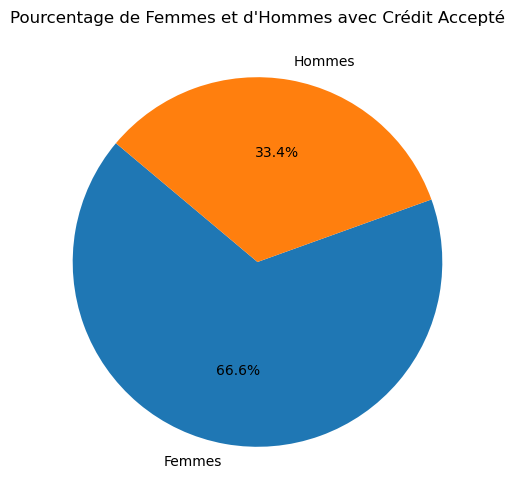

In [4]:
# Filtrer les données pour séparer les hommes et les femmes ayant un crédit accepté
credit_accepte = application_train[application_train['TARGET'] == 0]

# Compter le nombre de femmes et d'hommes ayant un crédit accepté
femmes_acceptees = credit_accepte[credit_accepte['CODE_GENDER'] == 'F'].shape[0]
hommes_acceptes = credit_accepte[credit_accepte['CODE_GENDER'] == 'M'].shape[0]

# Créer une liste pour les labels et une liste pour les valeurs
labels = ['Femmes', 'Hommes']
valeurs = [femmes_acceptees, hommes_acceptes]

# Créer le pie chart
plt.figure(figsize=(6, 6))
plt.pie(valeurs, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Pourcentage de Femmes et d\'Hommes avec Crédit Accepté')
plt.show()

Tout d'abord nous allon créer un décorateur python @contextmanager. 
Le context manager timer mesure le temps que prend une partie spécifique du code pour s'exécuter et imprime ce temps une fois cette partie terminée.  utilsé autour d'une portion de code, ce context manager permet de mesurer et de donner le temps écoulé pour exécuter cette partie de code.

In [5]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

Ensuite, comme nos modèles ne traitent que de variables numériques. Nous allons utiliser OneHotEncoder pour transformer les colonnes contenant des variables catégorielles en variables numériques reconnues par les différents modèles d'apprentissage automatique.

In [6]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

Ce code effectue le prétraitement (preprocessing) des données contenues dans les fichiers CSV "application_train.csv" et "application_test.csv". Voici une explication simple des différentes étapes réalisées :

Lecture des données :
La fonction commence par lire les fichiers CSV "application_train.csv" et "application_test.csv".
Les données lues depuis ces fichiers sont stockées dans les DataFrames df et test_df.
La taille des échantillons (nombre de lignes) pour les données d'entraînement (df) et de test (test_df) est imprimée.
Fusion des données de train et de test :
Les données des ensembles d'entraînement et de test sont fusionnées dans le DataFrame df.
Cela permet de manipuler et de prétraiter les données ensemble.
Nettoyage et préparation des données :
Certaines lignes où la colonne 'CODE_GENDER' a la valeur 'XNA' sont supprimées de df.
Les caractéristiques catégorielles ('CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY') sont encodées en utilisant la méthode de codage binaire.
Les caractéristiques catégorielles sont également encodées en utilisant la méthode one-hot encoding en utilisant une fonction one_hot_encoder.
Traitement des valeurs manquantes :
Les valeurs 365243 dans la colonne 'DAYS_EMPLOYED' sont remplacées par NaN (Not a Number), probablement considérées comme des valeurs aberrantes.
Création de nouvelles caractéristiques :
Quelques nouvelles caractéristiques sont créées en utilisant des opérations mathématiques sur les données existantes, telles que les pourcentages, les ratios, etc.
Nettoyage des variables temporaires :
La variable test_df est supprimée pour libérer de la mémoire.
La fonction gc.collect() est utilisée pour tenter de libérer davantage de mémoire en supprimant les objets non utilisés.
Renvoi des données nettoyées et transformées :
La fonction renvoie le DataFrame df qui contient les données nettoyées et prétraitées.
En résumé, ce code effectue diverses étapes pour préparer les données pour l'analyse ou l'entraînement de modèles, telles que la fusion des ensembles de données, le nettoyage des valeurs aberrantes et manquantes, l'encodage des caractéristiques catégorielles, la création de nouvelles caractéristiques et la libération de mémoire pour optimiser les performances.

In [7]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('/Users/soneitaraherimalala/Desktop/P7/Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv', nrows= num_rows, encoding='utf-8')
    test_df = pd.read_csv('/Users/soneitaraherimalala/Desktop/P7/Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv', nrows= num_rows, encoding='utf-8')
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

Pareil que pour le code ci-dessus. Ici, on fusionne les dataframes bureau et bureau_balance avec traitement des NaN, des 365243 valeurs abérrantes  et également transformation des colonnes catégorielles en variables numériques (binaires). 

In [8]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('/Users/soneitaraherimalala/Desktop/P7/Projet+Mise+en+prod+-+home-credit-default-risk/bureau.csv', nrows = num_rows, encoding='utf-8')
    bb = pd.read_csv('/Users/soneitaraherimalala/Desktop/P7/Projet+Mise+en+prod+-+home-credit-default-risk/bureau_balance.csv', nrows = num_rows, encoding='utf-8')
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

Ce code effectue le prétraitement (preprocessing) des données contenues dans le fichier CSV "previous_application.csv". Voici une explication simple des différentes étapes réalisées :

Lecture des données :
La fonction previous_applications lit le fichier CSV "previous_application.csv", stockant les données dans le DataFrame prev.
Encodage one-hot pour les données :
La fonction one_hot_encoder est utilisée pour effectuer un encodage one-hot sur le DataFrame prev. Cela crée de nouvelles colonnes binaires pour les caractéristiques catégorielles, et la fonction renvoie le DataFrame modifié ainsi que les noms des nouvelles colonnes.
Traitement des valeurs 365.243 :
Certaines valeurs spécifiques (365.243) dans différentes colonnes ('DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', etc.) sont considérées comme des données aberrantes et remplacées par NaN (Not a Number).
Création de nouvelles caractéristiques :
Une nouvelle caractéristique 'APP_CREDIT_PERC' est créée en divisant 'AMT_APPLICATION' par 'AMT_CREDIT'.
Agrégations des caractéristiques :
Différentes statistiques (comme min, max, moyenne, etc.) sont calculées pour plusieurs caractéristiques numériques ('AMT_ANNUITY', 'AMT_APPLICATION', etc.) et catégorielles (préalablement encodées en one-hot).
Ces agrégations sont effectuées en groupant les données par 'SK_ID_CURR' (l'identifiant unique du client).
Création de sous-ensembles de données et agrégations spécifiques :
Deux sous-ensembles de données ('approved' pour les applications approuvées et 'refused' pour les applications refusées) sont créés en fonction du statut de contrat.
Des agrégations spécifiques sont appliquées à ces sous-ensembles pour les caractéristiques numériques.
Libération de mémoire :
Pour libérer de la mémoire, les DataFrames temporaires sont supprimés.
Renvoi des données nettoyées et transformées :
La fonction renvoie le DataFrame prev_agg qui contient les données nettoyées et prétraitées pour une utilisation ultérieure dans des analyses ou des modèles d'apprentissage automatique.
En résumé, ce code réalise des opérations complexes telles que l'encodage, le traitement des valeurs aberrantes, la création de nouvelles caractéristiques et l'agrégation des données pour les rendre utilisables dans des analyses ou des modèles de prédiction ultérieurs.

In [9]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('/Users/soneitaraherimalala/Desktop/P7/Projet+Mise+en+prod+-+home-credit-default-risk/previous_application.csv', nrows = num_rows, encoding='utf-8')
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg


Ce code sert à prétraiter les données du fichier CSV "POS_CASH_balance.csv". Voici une explication simplifiée des différentes étapes réalisées :

Lecture des données :
La fonction pos_cash lit le fichier CSV "POS_CASH_balance.csv" et stocke les données dans le DataFrame pos.
Encodage one-hot pour les données :
La fonction one_hot_encoder est utilisée pour effectuer un encodage one-hot sur le DataFrame pos. Cela crée de nouvelles colonnes binaires pour les caractéristiques catégorielles, et la fonction renvoie le DataFrame modifié ainsi que les noms des nouvelles colonnes.
Agrégation des caractéristiques :
Différentes statistiques (comme max, moyenne, taille, etc.) sont calculées pour certaines caractéristiques numériques spécifiques ('MONTHS_BALANCE', 'SK_DPD', 'SK_DPD_DEF') et pour les caractéristiques catégorielles encodées en one-hot.
Ces agrégations sont effectuées en regroupant les données par 'SK_ID_CURR' (l'identifiant unique du client).
Création d'une nouvelle caractéristique :
Une nouvelle caractéristique 'POS_COUNT' est créée pour compter le nombre de comptes POS cash par 'SK_ID_CURR'.
Libération de mémoire :
Pour libérer de la mémoire, le DataFrame temporaire pos est supprimé.
Renvoi des données nettoyées et transformées :
La fonction renvoie le DataFrame pos_agg qui contient les données nettoyées et prétraitées pour une utilisation ultérieure dans des analyses ou des modèles d'apprentissage automatique.
En résumé, ce code prépare les données du fichier "POS_CASH_balance.csv" en effectuant des encodages, des agrégations et en créant de nouvelles caractéristiques pour rendre les données utilisables dans des analyses ou des modèles de prédiction ultérieurs.

In [10]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('/Users/soneitaraherimalala/Desktop/P7/Projet+Mise+en+prod+-+home-credit-default-risk/POS_CASH_balance.csv', nrows = num_rows, encoding='utf-8')
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

Ce code effectue le prétraitement (preprocessing) des données contenues dans le fichier CSV "installments_payments.csv". Voici une explication simplifiée des différentes étapes réalisées :

Lecture des données :
La fonction installments_payments lit le fichier CSV "installments_payments.csv" et stocke les données dans le DataFrame ins.
Encodage one-hot pour les données :
La fonction one_hot_encoder est utilisée pour effectuer un encodage one-hot sur le DataFrame ins. Cela crée de nouvelles colonnes binaires pour les caractéristiques catégorielles, et la fonction renvoie le DataFrame modifié ainsi que les noms des nouvelles colonnes.
Calcul de nouvelles caractéristiques :
De nouvelles caractéristiques sont créées pour évaluer le pourcentage de paiement et la différence de paiement pour chaque versement.
Des variables sont également créées pour mesurer les jours de retard (DPD) et les jours avant l'échéance (DBD), sans valeurs négatives.
Agrégation des caractéristiques :
Différentes statistiques (comme max, moyenne, somme, etc.) sont calculées pour plusieurs caractéristiques numériques spécifiques ('NUM_INSTALMENT_VERSION', 'DPD', 'DBD', etc.) et pour les caractéristiques catégorielles encodées en one-hot.
Ces agrégations sont effectuées en regroupant les données par 'SK_ID_CURR' (l'identifiant unique du client).
Création d'une nouvelle caractéristique :
Une nouvelle caractéristique 'INSTAL_COUNT' est créée pour compter le nombre de comptes d'installments par 'SK_ID_CURR'.
Libération de mémoire :
Pour libérer de la mémoire, le DataFrame temporaire ins est supprimé.
Renvoi des données nettoyées et transformées :
La fonction renvoie le DataFrame ins_agg qui contient les données nettoyées et prétraitées pour une utilisation ultérieure dans des analyses ou des modèles d'apprentissage automatique.
En résumé, ce code prépare les données du fichier "installments_payments.csv" en effectuant des encodages, des calculs de nouvelles caractéristiques, des agrégations statistiques et en créant de nouvelles variables pour rendre les données utilisables dans des analyses ou des modèles de prédiction ultérieurs.

In [11]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('/Users/soneitaraherimalala/Desktop/P7/Projet+Mise+en+prod+-+home-credit-default-risk/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

Ce code réalise le prétraitement (preprocessing) des données du fichier CSV "credit_card_balance.csv". Voici une explication simplifiée des étapes réalisées :

Lecture des données :
La fonction credit_card_balance lit le fichier CSV "credit_card_balance.csv" et stocke les données dans le DataFrame cc.
Encodage one-hot pour les données :
La fonction one_hot_encoder est utilisée pour effectuer un encodage one-hot sur le DataFrame cc. Cela crée de nouvelles colonnes binaires pour les caractéristiques catégorielles, et la fonction renvoie le DataFrame modifié ainsi que les noms des nouvelles colonnes.
Suppression de colonnes :
La colonne 'SK_ID_PREV' est supprimée du DataFrame cc car elle ne sera pas utilisée pour les agrégations.
Agrégations des caractéristiques :
Des agrégations statistiques (minimum, maximum, moyenne, somme, variance) sont calculées pour toutes les colonnes restantes dans le DataFrame cc.
Ces agrégations sont effectuées en regroupant les données par 'SK_ID_CURR' (l'identifiant unique du client).
Création d'une nouvelle caractéristique :
Une nouvelle caractéristique 'CC_COUNT' est créée pour compter le nombre de lignes de carte de crédit par 'SK_ID_CURR'.
Libération de mémoire :
Pour libérer de la mémoire, le DataFrame temporaire cc est supprimé.
Renvoi des données nettoyées et transformées :
La fonction renvoie le DataFrame cc_agg qui contient les données nettoyées et prétraitées pour une utilisation ultérieure dans des analyses ou des modèles d'apprentissage automatique.
En résumé, ce code prépare les données du fichier "credit_card_balance.csv" en effectuant des encodages, des agrégations statistiques et en créant une nouvelle variable pour rendre les données utilisables dans des analyses ou des modèles de prédiction ultérieurs.

In [12]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('/Users/soneitaraherimalala/Desktop/P7/Projet+Mise+en+prod+-+home-credit-default-risk/credit_card_balance.csv', nrows = num_rows, encoding='utf-8')
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

Ce code représente une fonction principale main() qui orchestre le prétraitement de différentes données, les agrège et les fusionne en un seul DataFrame pour une analyse ou une utilisation ultérieure dans un modèle d'apprentissage automatique.

Voici une explication étape par étape de ce que fait cette fonction :

Configuration du nombre de lignes :
Selon que le mode debug est activé ou non (défini par l'utilisateur), la variable num_rows est définie à 10000 si le mode debug est activé (True), sinon à None.
Prétraitement des données d'application :
La fonction application_train_test() est utilisée pour prétraiter les données d'application, stockées dans le DataFrame df.
Prétraitement des données de bureau et bureau_balance :
La fonction bureau_and_balance() est utilisée pour prétraiter les données de bureau et de balance associées, stockées dans le DataFrame bureau.
Les données prétraitées de bureau sont jointes avec le DataFrame principal df en utilisant la méthode join() et en fusionnant les données sur la colonne 'SK_ID_CURR'.
Ensuite, le DataFrame temporaire bureau est supprimé pour libérer de la mémoire.
Prétraitement des données de demandes précédentes :
La fonction previous_applications() est utilisée pour prétraiter les données des demandes précédentes, stockées dans le DataFrame prev.
Les données prétraitées des demandes précédentes sont jointes avec le DataFrame principal df de la même manière que pour le bureau.
Ensuite, le DataFrame temporaire prev est supprimé pour libérer de la mémoire.
Prétraitement des données POS-CASH balance :
La fonction pos_cash() est utilisée pour prétraiter les données de balance POS-CASH, stockées dans le DataFrame pos.
Les données prétraitées de POS-CASH sont jointes avec le DataFrame principal df de la même manière que pour le bureau et les demandes précédentes.
Ensuite, le DataFrame temporaire pos est supprimé pour libérer de la mémoire.
Prétraitement des données des paiements d'installments :
La fonction installments_payments() est utilisée pour prétraiter les données de paiements d'installments, stockées dans le DataFrame ins.
Les données prétraitées des paiements d'installments sont jointes avec le DataFrame principal df de la même manière que précédemment.
Ensuite, le DataFrame temporaire ins est supprimé pour libérer de la mémoire.
Prétraitement des données de balance de cartes de crédit :
La fonction credit_card_balance() est utilisée pour prétraiter les données de balance de cartes de crédit, stockées dans le DataFrame cc.
Les données prétraitées de balance de cartes de crédit sont jointes avec le DataFrame principal df de la même manière que précédemment.
Renvoi du DataFrame final :
La fonction retourne le DataFrame df, qui contient toutes les données prétraitées et fusionnées pour une utilisation ultérieure.

In [13]:
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
    return df

Tout ce preprocessing nous conduit à notre dataframe final avec tous les traitements effectués et également le temps de traitement.

In [14]:
data = main()

Train samples: 307511, test samples: 307511
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 9s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 8s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 5s
Installments payments df shape: (339587, 26)
Process installments payments - done in 14s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 6s


In [15]:
data

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615017,307506,456251,0,0,0,1,0,157500.0,254700.0,27558.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
615018,307507,456252,0,1,0,0,0,72000.0,269550.0,12001.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
615019,307508,456253,0,1,0,0,0,153000.0,677664.0,29979.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
615020,307509,456254,1,1,0,0,0,171000.0,370107.0,20205.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Ensuite, nous allons voir le nombre de valeurs manquantes par colonne, et nous n'allons garder que les colonnes avec un pourcentage de valeurs manquantes qui est inférieur à 5%.

In [16]:
D = (data.isnull().sum().sort_values().head(798))/615014
D

index                                    0.000000
OCCUPATION_TYPE_Medicine staff           0.000000
OCCUPATION_TYPE_Private service staff    0.000000
OCCUPATION_TYPE_Realty agents            0.000000
OCCUPATION_TYPE_Sales staff              0.000000
                                           ...   
REFUSED_RATE_DOWN_PAYMENT_MEAN           0.853116
REFUSED_RATE_DOWN_PAYMENT_MAX            0.853116
REFUSED_RATE_DOWN_PAYMENT_MIN            0.853116
REFUSED_AMT_DOWN_PAYMENT_MIN             0.853116
REFUSED_AMT_DOWN_PAYMENT_MAX             0.853116
Length: 798, dtype: float64

In [17]:
nombre_valeurs_manquantes = data['SK_ID_CURR'].isnull().sum()

# Affichage du nombre de valeurs manquantes dans la colonne spécifiée
print(f"Nombre de valeurs manquantes dans la colonne 'SK_ID_CURR': {nombre_valeurs_manquantes}")

Nombre de valeurs manquantes dans la colonne 'SK_ID_CURR': 0


Nous allons définir que pour notre étude que: la valeur 0 signifie que le prêt est remboursé la valeur 1 signifie que le prêt n'est pas remboursé.
Nous allons donc voir la distribution des clients selon que le prêt soit remboursé ou non dans la réalité. Pour ce faire, nous allons faire un barplot.

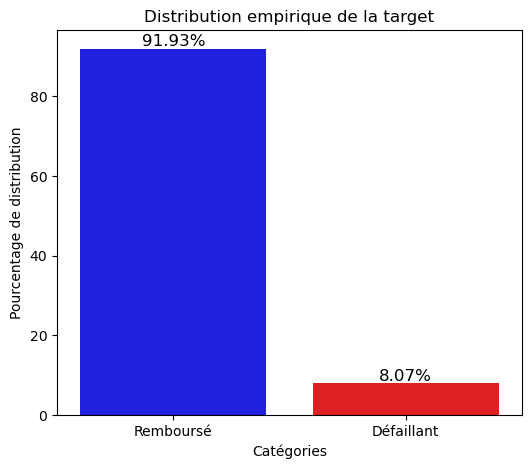

In [18]:

Imbalance = data
# Créez une figure et un axe
plt.figure(figsize=(6, 5))
ax = sns.barplot(x="TARGET", y="TARGET", data=Imbalance, palette=['b', 'r'], estimator=lambda x: len(x) / len(Imbalance) * 100)

# Personnalisez les étiquettes de l'axe des abscisses
ax.set_xticklabels(['Remboursé', 'Défaillant'])

# Ajoutez les pourcentages au-dessus des barres
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

# Personnalisez les étiquettes des axes, le titre, etc.
plt.ylabel('Pourcentage de distribution')
plt.xlabel('Catégories')
plt.title("Distribution empirique de la target")

# Affichez le graphique
plt.show()


On constate effectivement qu'il y a un dseséquilibre entre les 2 catégories du prêt remboursé de 91.93% et défaillant de 08.07%.

In [19]:
data['TARGET'].isnull().sum()

0

Ensuite, pour avoir une meilleure prédiction avec nos modèles, nous n'allons retenir dans le dataframe final que les colonnes ayant moins de 5% de NaN

In [20]:
# Calcul du pourcentage de valeurs manquantes par colonne
missing_percentages = (data.isnull().sum() / len(data)) * 100

# Sélection des colonnes avec moins de 5% de valeurs manquantes
selected_columns = missing_percentages[missing_percentages < 5].index.tolist()

# Création d'un nouveau DataFrame avec les colonnes sélectionnées
df = data[selected_columns]

# Affichage des noms des colonnes sélectionnées
print("Colonnes sélectionnées avec moins de 5% de valeurs manquantes :")
df

Colonnes sélectionnées avec moins de 5% de valeurs manquantes :


,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,...,0,0,1,0,1,0,0.498036,202500.0,0.121978,0.060749
1,1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,...,0,0,0,0,1,0,0.208736,135000.0,0.132217,0.027598
2,2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0,0.500000,67500.0,0.100000,0.050000
3,3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0,0.431748,67500.0,0.219900,0.094941
4,4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0,0.236842,121500.0,0.179963,0.042623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615017,307506,456251,0,0,0,1,0,157500.0,254700.0,27558.0,...,0,0,1,0,1,0,0.618375,157500.0,0.174971,0.108198
615018,307507,456252,0,1,0,0,0,72000.0,269550.0,12001.5,...,0,0,1,0,1,0,0.267112,72000.0,0.166687,0.044524
615019,307508,456253,0,1,0,0,0,153000.0,677664.0,29979.0,...,0,1,0,0,1,0,0.225776,153000.0,0.195941,0.044239
615020,307509,456254,1,1,0,0,0,171000.0,370107.0,20205.0,...,0,0,1,0,1,0,0.462029,85500.0,0.118158,0.054592


In [21]:
D = (df.isnull().sum().sort_values().head(194))/615014
D

index                             0.000000
ORGANIZATION_TYPE_Construction    0.000000
ORGANIZATION_TYPE_Culture         0.000000
ORGANIZATION_TYPE_Electricity     0.000000
ORGANIZATION_TYPE_Emergency       0.000000
                                    ...   
EXT_SOURCE_2                      0.002146
OBS_30_CNT_SOCIAL_CIRCLE          0.003320
DEF_30_CNT_SOCIAL_CIRCLE          0.003320
OBS_60_CNT_SOCIAL_CIRCLE          0.003320
DEF_60_CNT_SOCIAL_CIRCLE          0.003320
Length: 194, dtype: float64

In [22]:
df.columns


Index(['index', 'SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY',
       ...
       'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
       'WALLSMATERIAL_MODE_Stone, brick', 'WALLSMATERIAL_MODE_Wooden',
       'EMERGENCYSTATE_MODE_No', 'EMERGENCYSTATE_MODE_Yes',
       'INCOME_CREDIT_PERC', 'INCOME_PER_PERSON', 'ANNUITY_INCOME_PERC',
       'PAYMENT_RATE'],
      dtype='object', length=194)

Et finalement, nous remplacerons les valeurs manquantes des colonnes restantes par la moyenne des valeurs dans la colonne.

In [23]:
mean_per_column = df.mean()

# Remplacez les valeurs manquantes dans chaque colonne par la moyenne respective
df_filled = df.fillna(mean_per_column)

Ainsi donc, nous obtenons notre dataframe final que l'on nommera df_filled.

In [24]:
df_filled

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,...,0,0,1,0,1,0,0.498036,202500.0,0.121978,0.060749
1,1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,...,0,0,0,0,1,0,0.208736,135000.0,0.132217,0.027598
2,2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0,0.500000,67500.0,0.100000,0.050000
3,3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0,0.431748,67500.0,0.219900,0.094941
4,4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0,0.236842,121500.0,0.179963,0.042623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615017,307506,456251,0,0,0,1,0,157500.0,254700.0,27558.0,...,0,0,1,0,1,0,0.618375,157500.0,0.174971,0.108198
615018,307507,456252,0,1,0,0,0,72000.0,269550.0,12001.5,...,0,0,1,0,1,0,0.267112,72000.0,0.166687,0.044524
615019,307508,456253,0,1,0,0,0,153000.0,677664.0,29979.0,...,0,1,0,0,1,0,0.225776,153000.0,0.195941,0.044239
615020,307509,456254,1,1,0,0,0,171000.0,370107.0,20205.0,...,0,0,1,0,1,0,0.462029,85500.0,0.118158,0.054592


In [25]:
G = (df_filled.isnull().sum().sort_values().head(194))/615014
G

index                               0.0
ORGANIZATION_TYPE_Construction      0.0
ORGANIZATION_TYPE_Culture           0.0
ORGANIZATION_TYPE_Electricity       0.0
ORGANIZATION_TYPE_Emergency         0.0
                                   ... 
NAME_INCOME_TYPE_Maternity leave    0.0
NAME_INCOME_TYPE_Pensioner          0.0
NAME_INCOME_TYPE_State servant      0.0
FLAG_DOCUMENT_13                    0.0
PAYMENT_RATE                        0.0
Length: 194, dtype: float64

In [26]:
df_filled

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,...,0,0,1,0,1,0,0.498036,202500.0,0.121978,0.060749
1,1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,...,0,0,0,0,1,0,0.208736,135000.0,0.132217,0.027598
2,2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0,0.500000,67500.0,0.100000,0.050000
3,3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0,0.431748,67500.0,0.219900,0.094941
4,4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0,0.236842,121500.0,0.179963,0.042623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615017,307506,456251,0,0,0,1,0,157500.0,254700.0,27558.0,...,0,0,1,0,1,0,0.618375,157500.0,0.174971,0.108198
615018,307507,456252,0,1,0,0,0,72000.0,269550.0,12001.5,...,0,0,1,0,1,0,0.267112,72000.0,0.166687,0.044524
615019,307508,456253,0,1,0,0,0,153000.0,677664.0,29979.0,...,0,1,0,0,1,0,0.225776,153000.0,0.195941,0.044239
615020,307509,456254,1,1,0,0,0,171000.0,370107.0,20205.0,...,0,0,1,0,1,0,0.462029,85500.0,0.118158,0.054592


In [27]:
df_filled.columns

Index(['index', 'SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY',
       ...
       'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
       'WALLSMATERIAL_MODE_Stone, brick', 'WALLSMATERIAL_MODE_Wooden',
       'EMERGENCYSTATE_MODE_No', 'EMERGENCYSTATE_MODE_Yes',
       'INCOME_CREDIT_PERC', 'INCOME_PER_PERSON', 'ANNUITY_INCOME_PERC',
       'PAYMENT_RATE'],
      dtype='object', length=194)

In [28]:
nom_colonnes = pd.read_csv('/Users/soneitaraherimalala/Desktop/P7/Projet+Mise+en+prod+-+home-credit-default-risk/HomeCredit_columns_description.csv', sep="\t", encoding="latin-1", low_memory=False)
print(nom_colonnes)

                        ,Table,Row,Description,Special
0    1,application_{train|test}.csv,SK_ID_CURR,ID o...
1    2,application_{train|test}.csv,TARGET,"Target ...
2    5,application_{train|test}.csv,NAME_CONTRACT_T...
3    6,application_{train|test}.csv,CODE_GENDER,Gen...
4    7,application_{train|test}.csv,FLAG_OWN_CAR,Fl...
..                                                 ...
214  217,installments_payments.csv,NUM_INSTALMENT_N...
215  218,installments_payments.csv,DAYS_INSTALMENT,...
216  219,installments_payments.csv,DAYS_ENTRY_PAYME...
217  220,installments_payments.csv,AMT_INSTALMENT,W...
218  221,installments_payments.csv,AMT_PAYMENT,What...

[219 rows x 1 columns]


Ensuite, passons maintenant par la mise en place de MLFlow.

## Préparation de l’environnement d’expérimentation MLFlow

MLflow est une plateforme open-source développée par Databricks qui facilite la gestion de l'apprentissage automatique (ML) en fournissant des outils pour gérer le cycle de vie complet des projets de machine learning. Il a pour objectif de simplifier et  organiser le processus de développement, de suivi et de déploiement des modèles de machine learning, ce qui facilite la collaboration entre les équipes et améliore la productivité des praticiens en M 
MLFlow permet entre autres le suivi des paramètres et métriques pour chaque modèle entrainé, de comparer les différents modèles..., de manière standardisée.
Nous allons maintenant importer MLflow et ensuite identifier le port pour mettre le tracking.

In [29]:
import mlflow
from mlflow.models import infer_signature


In [30]:
mlflow.set_tracking_uri(uri="http://0.0.0.0:5500")

## Fonction de coût métier – Création d’un score métier

En banque, dans l'octroi des prêts, un faux négatifs c'est à dire un client incapable de rembourser son prêt consideré comme bon client dans le modèle cause 10 fois plus de perte que le faux négatif c'est-à-dire un client prédit comme ne pouvant pas rendre son prêt mais qui le peut  en réalité.
Pour cela, nous allons créer un score pour chaque client en tenant en compte ces valeurs (false_positive_cost = 1, Coût d'un faux positif et false_negative_cost = 10,Coût d'un faux négatif) et aussi une fonction permettant d'évaluer pour chaque modèle le pourcentage des clients dans chaque type Faux Négatifs, Faux Positifs, True Négatifs, True Positifs.

In [31]:
def custom_score(y_true, y_pred, false_positive_cost, false_negative_cost):
    # Calcul du nombre de faux positifs, de faux négatifs et de vrais positifs
    false_positives = ((y_true == 1) & (y_pred == 0)).sum()
    false_negatives = ((y_true == 0) & (y_pred == 1)).sum()
    true_positives = ((y_true == 0) & (y_pred == 0)).sum()

    # Calcul du score en fonction des coûts
    score = false_positive_cost * false_positives + false_negative_cost * false_negatives

    return -score  # Vous pouvez inverser le score si vous souhaitez minimiser le coût.

In [32]:
from sklearn.metrics import make_scorer

# Coûts des erreurs
false_positive_cost = 1  # Coût d'un faux positif
false_negative_cost = 10  # Coût d'un faux négatif

# Créez le scorer en utilisant make_scorer
custom_scorer = make_scorer(custom_score, greater_is_better=False, needs_proba=False,
                            false_positive_cost=false_positive_cost,
                            false_negative_cost=false_negative_cost)

## Développement et simulation de modèles

Pour notre cas, nous allons entrainer 3 modèles d'apprentissage différents: Catboost, XGBoost et RandomForest avec comme modèle de base DummyClassifier. Tout d'abord nous allons faire un GridSearchCv pour avoir les meilleurs hyperparamètres du modèle que l'on va entrainer après. Comme métriques d'évaluation, nous utiliserons l'AUC et le score métier que l'on a défini.

### DummyClassifier

C'est le modèle de base que nous allons utiliser.

In [33]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [34]:
X = df_filled.drop('TARGET', axis=1)
y = df_filled['TARGET']

In [35]:
X

,index,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,0,100002,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,0,0,1,0,1,0,0.498036,202500.0,0.121978,0.060749
1,1,100003,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,1,0,0.208736,135000.0,0.132217,0.027598
2,2,100004,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0,0,0.500000,67500.0,0.100000,0.050000
3,3,100006,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0,0,0.431748,67500.0,0.219900,0.094941
4,4,100007,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0,0,0.236842,121500.0,0.179963,0.042623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615017,307506,456251,0,0,1,0,157500.0,254700.0,27558.0,225000.0,...,0,0,1,0,1,0,0.618375,157500.0,0.174971,0.108198
615018,307507,456252,1,0,0,0,72000.0,269550.0,12001.5,225000.0,...,0,0,1,0,1,0,0.267112,72000.0,0.166687,0.044524
615019,307508,456253,1,0,0,0,153000.0,677664.0,29979.0,585000.0,...,0,1,0,0,1,0,0.225776,153000.0,0.195941,0.044239
615020,307509,456254,1,0,0,0,171000.0,370107.0,20205.0,319500.0,...,0,0,1,0,1,0,0.462029,85500.0,0.118158,0.054592


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
 X_test

,index,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
320952,13441,115668,0,1,0,0,270000.0,799299.0,33993.0,702000.0,...,0,1,0,0,1,0,0.337796,135000.0,0.125900,0.042529
508222,200711,332659,1,0,0,0,247500.0,450000.0,22500.0,450000.0,...,0,1,0,0,1,0,0.550000,247500.0,0.090909,0.050000
174081,174081,301736,1,0,0,0,112500.0,278460.0,21676.5,225000.0,...,0,1,0,0,1,0,0.404008,56250.0,0.192680,0.077844
237487,237487,375084,1,0,0,0,81000.0,157500.0,7875.0,157500.0,...,0,0,1,0,1,0,0.514286,81000.0,0.097222,0.050000
562866,255355,395470,0,1,0,0,135000.0,436032.0,25159.5,360000.0,...,0,0,0,0,0,0,0.309610,67500.0,0.186367,0.057701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87382,87382,201419,1,1,0,0,234000.0,1006069.5,31590.0,868500.0,...,0,0,0,0,0,0,0.232588,234000.0,0.135000,0.031399
425140,117629,236400,1,1,0,1,90000.0,573408.0,20727.0,495000.0,...,0,0,0,0,0,0,0.156956,30000.0,0.230300,0.036147
270002,270002,412923,0,1,0,0,225000.0,180000.0,9000.0,180000.0,...,0,0,1,0,1,0,1.250000,112500.0,0.040000,0.050000
225242,225242,360902,1,0,0,0,112500.0,310500.0,22725.0,310500.0,...,0,0,0,0,0,0,0.362319,56250.0,0.202000,0.073188


In [38]:
# Créez un modèle DummyClassifier avec la stratégie "stratified"
dummy_clf = DummyClassifier(strategy="stratified")

In [39]:
dummy_clf.fit(X_train, y_train)


DummyClassifier(strategy='stratified')

In [40]:
y_pred = dummy_clf.predict(X_test)

L'AUC ou Aire sous la courbe est une métrique utilisée dans les modèles de classification binaire comme notre cas, qui représente la relation entre le taux de vrais positifs (TPR - True Positive Rate) et le taux de faux positifs (FPR - False Positive Rate) pour différentes valeurs de seuil de classification. Plus la valeur de l'AUC est proche de 1, plus le modèle est bon.

In [41]:
auc = roc_auc_score(y_test, y_pred)
print("AUC:", auc)

AUC: 0.49845598505812344


Dans cette dernière partie, nous définissons, la fonction de tracking pour MLFlow.

In [42]:
# Enregistrement de l'exécution avec MLflow
with mlflow.start_run() as run:
    # Création et entraînement du modèle DummyClassifier
    dummy_clf = DummyClassifier(strategy="stratified")
    dummy_clf.fit(X_train, y_train)
    
    # Prédiction et calcul de l'AUC sur les données de test
    y_pred = dummy_clf.predict(X_test)
    auc = roc_auc_score(y_test, y_pred)
    
    # Calcul de la courbe ROC pour les données de test
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    
    # Enregistrement des métriques dans MLflow
    mlflow.log_param("dummymodel", "DummyClassifier")
    mlflow.log_metric("AUC_test_DummyClassifier", auc)
    
    # Enregistrement de la courbe ROC dans MLflow
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Test)')
    plt.legend(loc="lower right")
    
    # Enregistrement de la courbe ROC en tant qu'artefact
    roc_fig = "ROC_curve_test.png"
    plt.savefig(roc_fig)
    mlflow.log_artifact(roc_fig)
    plt.close()
    
    # Log the sklearn model and register as version 1
    mlflow.sklearn.log_model(
        sk_model=dummy_clf,
        artifact_path="sklearn-model",
        #signature=signature,
        registered_model_name="sk-learn-dummy_clf-model",
    )


Registered model 'sk-learn-dummy_clf-model' already exists. Creating a new version of this model...
2023/12/12 10:34:21 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: sk-learn-dummy_clf-model, version 11
Created version '11' of model 'sk-learn-dummy_clf-model'.


CatBoost

CatBoost Classifier est un modèle d'apprentissage automatique pour la classification. Il s'agit d'une implémentation de boosting gradient basée sur des arbres de décision, spécifiquement conçue pour être performante avec des données catégorielles.

In [34]:
import catboost
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import GridSearchCV

In [44]:
X = df_filled.drop('TARGET', axis=1)
y = df_filled['TARGET']

In [45]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [46]:
 X_test

,index,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
320952,13441,115668,0,1,0,0,270000.0,799299.0,33993.0,702000.0,...,0,1,0,0,1,0,0.337796,135000.0,0.125900,0.042529
508222,200711,332659,1,0,0,0,247500.0,450000.0,22500.0,450000.0,...,0,1,0,0,1,0,0.550000,247500.0,0.090909,0.050000
174081,174081,301736,1,0,0,0,112500.0,278460.0,21676.5,225000.0,...,0,1,0,0,1,0,0.404008,56250.0,0.192680,0.077844
237487,237487,375084,1,0,0,0,81000.0,157500.0,7875.0,157500.0,...,0,0,1,0,1,0,0.514286,81000.0,0.097222,0.050000
562866,255355,395470,0,1,0,0,135000.0,436032.0,25159.5,360000.0,...,0,0,0,0,0,0,0.309610,67500.0,0.186367,0.057701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87382,87382,201419,1,1,0,0,234000.0,1006069.5,31590.0,868500.0,...,0,0,0,0,0,0,0.232588,234000.0,0.135000,0.031399
425140,117629,236400,1,1,0,1,90000.0,573408.0,20727.0,495000.0,...,0,0,0,0,0,0,0.156956,30000.0,0.230300,0.036147
270002,270002,412923,0,1,0,0,225000.0,180000.0,9000.0,180000.0,...,0,0,1,0,1,0,1.250000,112500.0,0.040000,0.050000
225242,225242,360902,1,0,0,0,112500.0,310500.0,22725.0,310500.0,...,0,0,0,0,0,0,0.362319,56250.0,0.202000,0.073188


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
catboost_model = CatBoostClassifier()  

Nous allons effectuer un GridSearchCv avec les valeurs de paramètres suivants.

In [49]:
param_grid = {'iterations': [100, 200],
    'learning_rate': [0.01, 0.1],
    'depth': [3, 6]
}

In [50]:
# Créez un objet GridSearchCV en spécifiant le modèle, le paramètre de la grille et la métrique à optimiser (par exemple, 'roc_auc')
grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, scoring=custom_scorer, cv=3)

In [51]:
# Entraînez le modèle de recherche sur grille sur les données d'entraînement
grid_search.fit(X_train, y_train)

0:	learn: 0.6829093	total: 85ms	remaining: 8.42s
1:	learn: 0.6728303	total: 105ms	remaining: 5.15s
2:	learn: 0.6626072	total: 122ms	remaining: 3.94s
3:	learn: 0.6526182	total: 152ms	remaining: 3.65s
4:	learn: 0.6433065	total: 181ms	remaining: 3.44s
5:	learn: 0.6339110	total: 206ms	remaining: 3.23s
6:	learn: 0.6251727	total: 222ms	remaining: 2.95s
7:	learn: 0.6161536	total: 241ms	remaining: 2.77s
8:	learn: 0.6073779	total: 258ms	remaining: 2.61s
9:	learn: 0.5989298	total: 274ms	remaining: 2.46s
10:	learn: 0.5910267	total: 292ms	remaining: 2.36s
11:	learn: 0.5829620	total: 311ms	remaining: 2.28s
12:	learn: 0.5754504	total: 330ms	remaining: 2.21s
13:	learn: 0.5677890	total: 348ms	remaining: 2.14s
14:	learn: 0.5603393	total: 367ms	remaining: 2.08s
15:	learn: 0.5531135	total: 384ms	remaining: 2.02s
16:	learn: 0.5460262	total: 399ms	remaining: 1.95s
17:	learn: 0.5390566	total: 415ms	remaining: 1.89s
18:	learn: 0.5324353	total: 430ms	remaining: 1.83s
19:	learn: 0.5261532	total: 446ms	remainin

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x1576b3a90>,
             param_grid={'depth': [3, 6], 'iterations': [100, 200],
                         'learning_rate': [0.01, 0.1]},
             scoring=make_scorer(custom_score, greater_is_better=False, false_positive_cost=1, false_negative_cost=10))

In [52]:
# Affichez les meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres:", grid_search.best_params_)

Meilleurs hyperparamètres: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}


Ensuite, nous allons entrainer notre modèle avec les meilleurs hyperparamètres.

In [53]:
catboost_model1 = CatBoostClassifier(iterations=200,  # Nombre d'itérations (arbres)
                                    learning_rate=0.1,  # Taux d'apprentissage
                                    depth=6,  # Profondeur de l'arbre
                                    loss_function='Logloss',  # Fonction de perte
                                    )  # Indices des caractéristiques catégorielles

In [54]:
# Entraînez le modèle sur les données d'entraînement
catboost_model1.fit(X_train, y_train)

0:	learn: 0.5929139	total: 39.3ms	remaining: 7.82s
1:	learn: 0.5198767	total: 69.3ms	remaining: 6.86s
2:	learn: 0.4619287	total: 99.9ms	remaining: 6.56s
3:	learn: 0.4163395	total: 135ms	remaining: 6.61s
4:	learn: 0.3825249	total: 174ms	remaining: 6.79s
5:	learn: 0.3562402	total: 213ms	remaining: 6.89s
6:	learn: 0.3366439	total: 255ms	remaining: 7.03s
7:	learn: 0.3214152	total: 293ms	remaining: 7.03s
8:	learn: 0.3096275	total: 331ms	remaining: 7.02s
9:	learn: 0.3008464	total: 375ms	remaining: 7.12s
10:	learn: 0.2926542	total: 422ms	remaining: 7.25s
11:	learn: 0.2869424	total: 477ms	remaining: 7.48s
12:	learn: 0.2822592	total: 524ms	remaining: 7.53s
13:	learn: 0.2785663	total: 568ms	remaining: 7.54s
14:	learn: 0.2749550	total: 610ms	remaining: 7.52s
15:	learn: 0.2722197	total: 655ms	remaining: 7.54s
16:	learn: 0.2700770	total: 695ms	remaining: 7.48s
17:	learn: 0.2684411	total: 734ms	remaining: 7.42s
18:	learn: 0.2669427	total: 772ms	remaining: 7.35s
19:	learn: 0.2655800	total: 812ms	rema

In [55]:
from sklearn.metrics import classification_report

In [56]:
grid_search_model = grid_search.best_estimator_
y_pred_grid = grid_search_model.predict(X_test)
 
# Print classification report for the Grid Search model
print("Grid Search - Classification Report:")
print(classification_report(y_test, y_pred_grid))

Grid Search - Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    113050
           1       0.64      0.01      0.01      9953

    accuracy                           0.92    123003
   macro avg       0.78      0.50      0.49    123003
weighted avg       0.90      0.92      0.88    123003



Ensuite, pour évaluer la probabilité de la classe positive , nous ferons un predict_proba(X_test)[:, 1]. Puis, nous calculons l'AUC du X_test et du X_train , et comparer les deux valeurs obtenues. Les valeurs doivent être proches pour dire qu'il n'y a pas de dataleakage.

In [57]:
y_pred_proba1_test = catboost_model1.predict_proba(X_test)[:, 1]  # Probabilité de la classe positive

In [58]:
y_pred_proba1_train = catboost_model1.predict_proba(X_train)[:, 1]  # Probabilité de la classe positive

In [59]:
y_pred = catboost_model1.predict(X_test)

In [60]:
auc_test = roc_auc_score(y_test, y_pred_proba1_test)
print("AUC_test:", auc_test)

AUC_test: 0.741973277944597


In [61]:
auc_train = roc_auc_score(y_train, y_pred_proba1_train)
print("AUC_train:", auc_train)

AUC_train: 0.7490300276846658


Ensuite, nous allons faire la matrice de confusion.

In [62]:
# view confusion-matrix
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[113013     37]
 [  9886     67]]

True Positives(TP) =  113013

True Negatives(TN) =  67

False Positives(FP) =  37

False Negatives(FN) =  9886


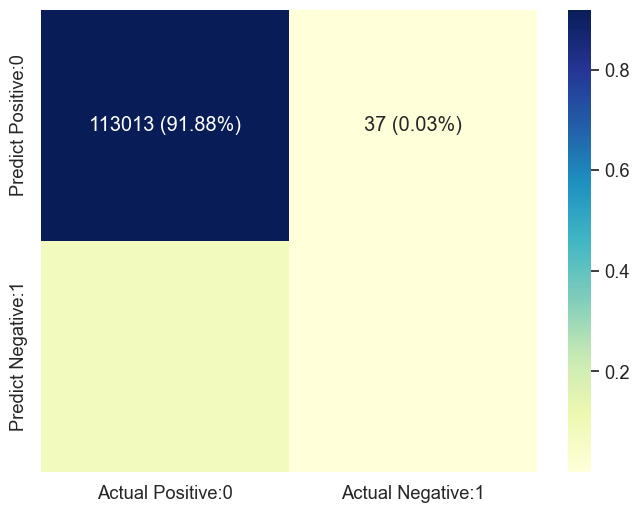

In [63]:
# Votre matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Calcul des pourcentages
total_samples = cm.sum()
cm_percentage = cm.astype('float') / total_samples

# Création d'une DataFrame pour stocker les pourcentages
cm_percentage_df = pd.DataFrame(data=cm_percentage, columns=['Actual Positive:0', 'Actual Negative:1'],
                                index=['Predict Positive:0', 'Predict Negative:1'])

# Création d'une DataFrame vide pour stocker les annotations
annotations = pd.DataFrame(columns=['Actual Positive:0', 'Actual Negative:1'],
                            index=['Predict Positive:0', 'Predict Negative:1'])

# Boucle pour ajouter les pourcentages aux annotations
for i in range(2):
    for j in range(2):
        annotations.iloc[i, j] = f"{cm[i, j]} ({cm_percentage_df.iloc[i, j]*100:.2f}%)"

# Ajout du nombre et du pourcentage de faux négatifs et de vrais négatifs
annotations.iloc[1, 0] = f"{cm[1, 0]} ({cm_percentage[1, 0]*100:.2f}%)"
annotations.iloc[1, 1] = f"{cm[1, 1]} ({cm_percentage[1, 1]*100:.2f}%)"

# Configuration du graphique
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)

# Création de la heatmap avec les annotations
sns.heatmap(cm_percentage_df, annot=annotations, fmt="", cmap='YlGnBu')

plt.show()

Puis, nous allons calculer un seuil maximal en dessous duquel, les valeurs sont considerées comme 0(prêt remboursé), ce seuil est calculé à partir du score métier défini plus haut.

In [64]:
# Étape 2 : Calculez les scores en utilisant la métrique personnalisée
thresholds = np.arange(0.1, 0.9, 0.1)  # Vous pouvez ajuster l'intervalle
best_score = float('-inf')  # Initialisez le meilleur score à négatif infini
best_threshold = 0

In [65]:
for threshold in thresholds:
    y_pred = (y_pred_proba1_test > threshold).astype(int)
    current_score = abs(custom_score(y_test, y_pred, false_positive_cost=1, false_negative_cost=10))
    
    print(f"threshold {threshold} score {current_score}")

    if current_score > best_score:
        best_score = current_score
        best_threshold = threshold

# Étape 3 : Sélectionnez le seuil optimal
print("Meilleur seuil (score personnalisé) : {:.2f}".format(best_threshold))

threshold 0.1 score 256122
threshold 0.2 score 59364
threshold 0.30000000000000004 score 20228
threshold 0.4 score 11992
threshold 0.5 score 10256
threshold 0.6000000000000001 score 10003
threshold 0.7000000000000001 score 9973
threshold 0.8 score 9953
Meilleur seuil (score personnalisé) : 0.10


In [66]:
# Enregistrement de l'exécution avec MLflow
with mlflow.start_run() as run:
    # Création et entraînement du modèle CatBoost
    catboost_model = CatBoostClassifier(iterations=200, learning_rate=0.1, depth=6, loss_function='Logloss')
    catboost_model.fit(X_train, y_train)
    
    # Prédiction et calcul de l'AUC sur les données de test
    y_pred_proba_test = catboost_model.predict_proba(X_test)[:, 1]
    auc_test = roc_auc_score(y_test, y_pred_proba_test)
    current_score = abs(custom_score(y_test, y_pred, false_positive_cost=1, false_negative_cost=10))
    
    # Calcul de la courbe ROC pour les données de test
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba_test)
    # Enregistrement de la courbe ROC dans MLflow
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_test)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Test)')
    plt.legend(loc="lower right")
    
    # Enregistrement des métriques dans MLflow
    mlflow.log_param("catboostmodel", "CatBoostClassifier")
    mlflow.log_metric("AUC_test_CatBoostClassifier", auc_test)
    mlflow.log_metric("score_test_CatBoostClassifier", current_score)
    
    # Enregistrement du modèle CatBoost dans MLflow
    mlflow.catboost.log_model(catboost_model, "catboost-model")
    
    # Enregistrement de la courbe ROC en tant qu'artefact
    roc_fig_cat = "ROC_curve_test1.png"
    plt.savefig(roc_fig_cat)
    mlflow.log_artifact(roc_fig_cat)
    plt.close()
    
    # Log the sklearn model and register as version 1
    mlflow.sklearn.log_model(
        sk_model=catboost_model1 ,
        artifact_path="sklearn-catboostmodel",
        #signature=signature,
        registered_model_name="sk-learn-CatBoostClassifier-model",
    )


0:	learn: 0.5929139	total: 38.2ms	remaining: 7.61s
1:	learn: 0.5198767	total: 65.8ms	remaining: 6.51s
2:	learn: 0.4619287	total: 96.3ms	remaining: 6.32s
3:	learn: 0.4163395	total: 126ms	remaining: 6.16s
4:	learn: 0.3825249	total: 154ms	remaining: 6s
5:	learn: 0.3562402	total: 182ms	remaining: 5.88s
6:	learn: 0.3366439	total: 211ms	remaining: 5.83s
7:	learn: 0.3214152	total: 236ms	remaining: 5.67s
8:	learn: 0.3096275	total: 268ms	remaining: 5.69s
9:	learn: 0.3008464	total: 303ms	remaining: 5.75s
10:	learn: 0.2926542	total: 339ms	remaining: 5.83s
11:	learn: 0.2869424	total: 373ms	remaining: 5.85s
12:	learn: 0.2822592	total: 410ms	remaining: 5.89s
13:	learn: 0.2785663	total: 438ms	remaining: 5.82s
14:	learn: 0.2749550	total: 467ms	remaining: 5.76s
15:	learn: 0.2722197	total: 500ms	remaining: 5.75s
16:	learn: 0.2700770	total: 531ms	remaining: 5.71s
17:	learn: 0.2684411	total: 563ms	remaining: 5.69s
18:	learn: 0.2669427	total: 596ms	remaining: 5.67s
19:	learn: 0.2655800	total: 627ms	remaini

Registered model 'sk-learn-CatBoostClassifier-model' already exists. Creating a new version of this model...
2023/12/12 11:57:48 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: sk-learn-CatBoostClassifier-model, version 11
Created version '11' of model 'sk-learn-CatBoostClassifier-model'.


Pour tous les modèles, nous allons procéder de la même manière.

XGBOOST

In [35]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [68]:
X = df_filled.drop('TARGET', axis=1)
y = df_filled['TARGET']

In [69]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
 X_test

array([[-1.58064318, -1.58102521, -1.38816188, ...,  0.41326335,
        -0.58189454, -0.49671251],
       [ 0.52894825,  0.52998824,  0.72037708, ...,  1.52302162,
        -0.95188673, -0.16436406],
       [ 0.22896202,  0.22915148,  0.72037708, ..., -0.36356744,
         0.12423397,  1.07420932],
       ...,
       [ 1.30950946,  1.31084266, -1.38816188, ...,  0.1913117 ,
        -1.490197  , -0.16436406],
       [ 0.80528929,  0.80475241,  0.72037708, ..., -0.36356744,
         0.2227832 ,  0.86710846],
       [-0.37680061, -0.37632591,  0.72037708, ..., -0.25259161,
        -0.54136106,  0.75308038]])

In [72]:
# Créez un modèle XGBoost Classifier
xgb_model = xgb.XGBClassifier()

In [73]:
# Définissez la grille de paramètres à tester
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300]
}

In [74]:
# Créez un objet GridSearchCV en spécifiant le modèle, le paramètre de la grille et la métrique à optimiser (par exemple, 'roc_auc')
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring=custom_scorer, cv=3)

In [75]:
# Entraînez le modèle de recherche sur grille sur les données d'entraînement
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             scoring=make_scorer(custom_score, greater_is_better=False, false_positive_cost=1, false_negative_cost=10))

In [76]:
# Afficher les meilleurs hyperparamètres et la meilleure performance
print("Meilleurs hyperparamètres :", grid_search.best_params_)

Meilleurs hyperparamètres : {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}


In [77]:
xgb_model1 = XGBClassifier(
    learning_rate=0.1,  # Taux d'apprentissage
    n_estimators=300,   # Nombre d'arbres (itérations)
    max_depth=5,       # Profondeur maximale de l'arbre
    objective='binary:logistic',  # Problème de classification binaire
    use_label_encoder=False,      # Désactiver l'encodage automatique des étiquettes
)

In [78]:
# Entraînez le modèle sur les données d'entraînement
xgb_model1.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [79]:
# Faites des prédictions sur l'ensemble de test
y_pred2 = xgb_model1.predict(X_test)

In [80]:
y_pred_proba2_test = xgb_model1.predict_proba(X_test)[:, 1]  # Probabilité de la classe positive

In [81]:
y_pred_proba2_train = xgb_model1.predict_proba(X_train)[:, 1]  # Probabilité de la classe positive

In [82]:
auc_test = roc_auc_score(y_test, y_pred_proba2_test)
print("auc_test:", auc_test)

auc_test: 0.768855820498759


In [83]:
auc_train = roc_auc_score(y_train, y_pred_proba2_train)
print("auc_train:", auc_train)

auc_train: 0.8016536674529707


In [84]:

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred2)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[112971     79]
 [  9809    144]]

True Positives(TP) =  112971

True Negatives(TN) =  144

False Positives(FP) =  79

False Negatives(FN) =  9809


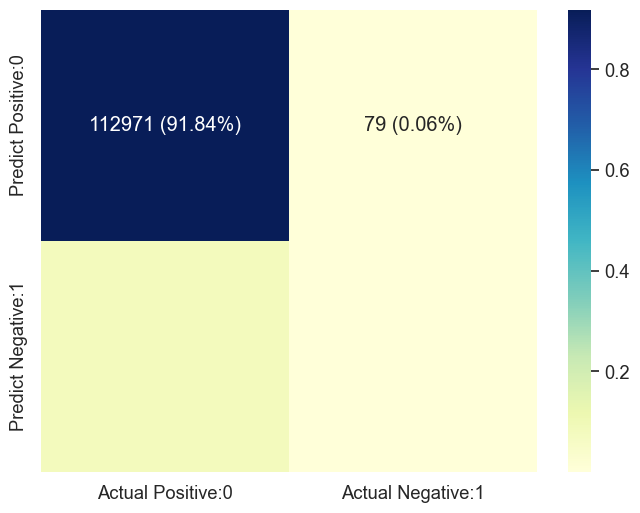

In [85]:
# Suppose cm is your confusion matrix
cm = confusion_matrix(y_test, y_pred2)

# Calculate the total number of samples
total_samples = cm.sum()

# Calculate percentages
cm_percentage = cm.astype('float') / total_samples  # Normalize by dividing by the total number of samples

# Create a DataFrame from the percentage matrix
cm_percentage_df = pd.DataFrame(data=cm_percentage, columns=['Actual Positive:0', 'Actual Negative:1'],
                                index=['Predict Positive:0', 'Predict Negative:1'])

# Create an empty DataFrame to store both number and percentage annotations
annotations = pd.DataFrame(columns=['Actual Positive:0', 'Actual Negative:1'],
                            index=['Predict Positive:0', 'Predict Negative:1'])

# Loop through the confusion matrix and add both number and percentage annotations
for i in range(2):
    for j in range(2):
        annotations.iloc[i, j] = f"{cm[i, j]} ({cm_percentage_df.iloc[i, j]*100:.2f}%)"

# Set up the figure
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size

# Create the heatmap with annotations
sns.heatmap(cm_percentage_df, annot=annotations, fmt="", cmap='YlGnBu')

plt.show()
#Ce code prend en compte le nombre total d'individus dans la variable total_samples et calcule le pourcentage en divisant par ce nombre total. Les annotations comprennent à la fois le nombre et le pourcentage. Le format d'affichage des pourcentages peut également être ajusté selon vos préférences.


In [86]:
grid_search_model = grid_search.best_estimator_
y_pred_grid = grid_search_model.predict(X_test)
 
# Print classification report for the Grid Search model
print("Grid Search - Classification Report:")
print(classification_report(y_test, y_pred2))

Grid Search - Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    113050
           1       0.65      0.01      0.03      9953

    accuracy                           0.92    123003
   macro avg       0.78      0.51      0.49    123003
weighted avg       0.90      0.92      0.88    123003



In [87]:
# Étape 2 : Calculez les scores en utilisant votre métrique personnalisée
thresholds = np.arange(0.1, 0.9, 0.1)  # Vous pouvez ajuster l'intervalle
best_score = float('-inf')  # Initialisez le meilleur score à négatif infini
best_threshold = 0

In [88]:
for threshold in thresholds:
    y_pred = (y_pred_proba2_test > threshold).astype(int)
    current_score = abs(custom_score(y_test, y_pred, false_positive_cost=1, false_negative_cost=10))
    print(f"threshold {threshold} score {current_score}")

    if current_score > best_score:
        best_score = current_score
        best_threshold = threshold

# Étape 3 : Sélectionnez le seuil optimal
print("Meilleur seuil (score personnalisé) : {:.2f}".format(best_threshold))

threshold 0.1 score 252840
threshold 0.2 score 65611
threshold 0.30000000000000004 score 24357
threshold 0.4 score 13667
threshold 0.5 score 10599
threshold 0.6000000000000001 score 10038
threshold 0.7000000000000001 score 9952
threshold 0.8 score 9953
Meilleur seuil (score personnalisé) : 0.10


In [89]:
with mlflow.start_run() as run:
    # Création et entraînement du modèle XGBoost
    xgb_model = XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=300)
    xgb_model.fit(X_train, y_train)
    
    # Prédiction et calcul de l'AUC sur les données de test
    y_pred_proba_test = xgb_model.predict_proba(X_test)[:, 1]
    auc_test2 = roc_auc_score(y_test, y_pred_proba2_test)
    current_score = abs(custom_score(y_test, y_pred, false_positive_cost=1, false_negative_cost=10))
    
    # Calcul de la courbe ROC pour les données de test
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba2_test)
    
    # Enregistrement de la courbe ROC dans MLflow
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_test2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Test)')
    plt.legend(loc="lower right")
    
    # Enregistrement des métriques dans MLflow
    mlflow.log_param("xgbmodel", "XGBoostClassifier")
    mlflow.log_metric("AUC_test_XGBoostClassifier", auc_test2)
    mlflow.log_metric("score_test_XGBoostClassifier", current_score)
    
    # Enregistrement du modèle XGBoost dans MLflow
    mlflow.xgboost.log_model(xgb_model, "xgboost-model")
    
    # Enregistrement de la courbe ROC en tant qu'artefact
    roc_fig_xgb = "ROC_curve_test_xgb.png"
    plt.savefig(roc_fig_xgb)
    mlflow.log_artifact(roc_fig_xgb)
    plt.close()

      # Log the sklearn model and register as version 1
    mlflow.sklearn.log_model(
        sk_model=xgb_model ,
        artifact_path="sklearn-xgb_model",
        #signature=signature,
        registered_model_name="sk-learn-xgb_model-model",
    )

Registered model 'sk-learn-xgb_model-model' already exists. Creating a new version of this model...
2023/12/12 12:22:29 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: sk-learn-xgb_model-model, version 7
Created version '7' of model 'sk-learn-xgb_model-model'.


RandomForest

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [91]:
X = df_filled.drop('TARGET', axis=1)
y = df_filled['TARGET']

In [92]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [94]:
rf_model = RandomForestClassifier()

In [95]:
# Définir les hyperparamètres à rechercher
hyperparameters = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10]}

In [96]:
grid_search = GridSearchCV(estimator=rf_model, param_grid=hyperparameters, scoring=custom_scorer, cv=3)

In [97]:
# Entraînez le modèle de recherche sur grille sur les données d'entraînement
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 5, 10],
                         'n_estimators': [10, 50, 100]},
             scoring=make_scorer(custom_score, greater_is_better=False, false_positive_cost=1, false_negative_cost=10))

In [98]:
# Afficher les meilleurs hyperparamètres et la meilleure performance
print("Meilleurs hyperparamètres :", grid_search.best_params_)

Meilleurs hyperparamètres : {'max_depth': 10, 'n_estimators': 10}


In [99]:
rf1_model = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_split=10, random_state=42)

In [100]:
rf1_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_split=10, n_estimators=10,
                       random_state=42)

In [101]:
y_pred_proba3_test = rf1_model.predict_proba(X_test)[:, 1]  # Probabilité de la classe positive

In [102]:
y_pred_proba3_train = rf1_model.predict_proba(X_train)[:, 1]  # Probabilité de la classe positive

In [103]:
# Faites des prédictions sur l'ensemble de test
y_pred3 = rf1_model.predict(X_test)

In [104]:
auc_test = roc_auc_score(y_test, y_pred_proba3_test)
print("AUC_test:", auc_test)

AUC_test: 0.6719401905452753


In [105]:
auc_train = roc_auc_score(y_train, y_pred_proba3_train)
print("AUC_train:", auc_train)

AUC_train: 0.677596164342579


In [106]:

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred3)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[113050      0]
 [  9953      0]]

True Positives(TP) =  113050

True Negatives(TN) =  0

False Positives(FP) =  0

False Negatives(FN) =  9953


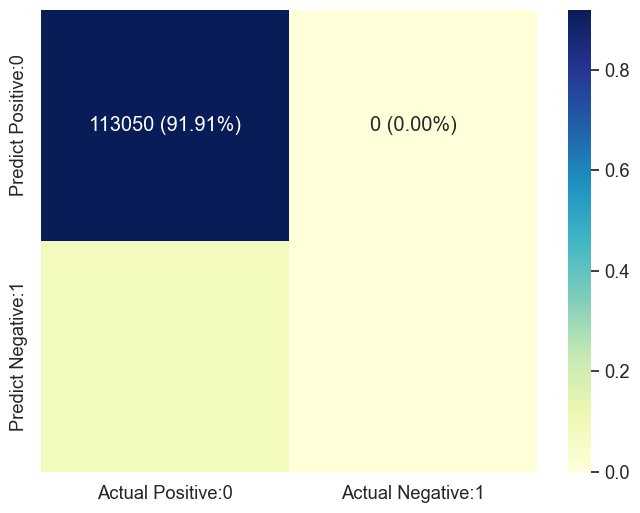

In [107]:
# Suppose cm is your confusion matrix
cm = confusion_matrix(y_test, y_pred3)

# Calculate the total number of samples
total_samples = cm.sum()

# Calculate percentages
cm_percentage = cm.astype('float') / total_samples  # Normalize by dividing by the total number of samples

# Create a DataFrame from the percentage matrix
cm_percentage_df = pd.DataFrame(data=cm_percentage, columns=['Actual Positive:0', 'Actual Negative:1'],
                                index=['Predict Positive:0', 'Predict Negative:1'])

# Create an empty DataFrame to store both number and percentage annotations
annotations = pd.DataFrame(columns=['Actual Positive:0', 'Actual Negative:1'],
                            index=['Predict Positive:0', 'Predict Negative:1'])

# Loop through the confusion matrix and add both number and percentage annotations
for i in range(2):
    for j in range(2):
        annotations.iloc[i, j] = f"{cm[i, j]} ({cm_percentage_df.iloc[i, j]*100:.2f}%)"

# Set up the figure
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size

# Create the heatmap with annotations
sns.heatmap(cm_percentage_df, annot=annotations, fmt="", cmap='YlGnBu')

plt.show()
#Ce code prend en compte le nombre total d'individus dans la variable total_samples et calcule le pourcentage en divisant par ce nombre total. Les annotations comprennent à la fois le nombre et le pourcentage. Le format d'affichage des pourcentages peut également être ajusté selon vos préférences.


In [108]:
grid_search_model = grid_search.best_estimator_
y_pred_grid = grid_search_model.predict(X_test)
 
# Print classification report for the Grid Search model
print("Grid Search - Classification Report:")
print(classification_report(y_test, y_pred3))

Grid Search - Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    113050
           1       0.00      0.00      0.00      9953

    accuracy                           0.92    123003
   macro avg       0.46      0.50      0.48    123003
weighted avg       0.84      0.92      0.88    123003



In [109]:
# Étape 2 : Calculez les scores en utilisant votre métrique personnalisée
thresholds = np.arange(0.1, 0.9, 0.1)  # Vous pouvez ajuster l'intervalle
best_score = float('-inf')  # Initialisez le meilleur score à négatif infini
best_threshold = 0

In [110]:
for threshold in thresholds:
    y_pred = (y_pred_proba3_test > threshold).astype(int)
    current_score = abs(custom_score(y_test, y_pred, false_positive_cost=1, false_negative_cost=10))
    print(f"threshold {threshold} score {current_score}")

    if current_score > best_score:
        best_score = current_score
        best_threshold = threshold

# Étape 3 : Sélectionnez le seuil optimal
print("Meilleur seuil (score personnalisé) : {:.2f}".format(best_threshold))

threshold 0.1 score 160535
threshold 0.2 score 9967
threshold 0.30000000000000004 score 9953
threshold 0.4 score 9953
threshold 0.5 score 9953
threshold 0.6000000000000001 score 9953
threshold 0.7000000000000001 score 9953
threshold 0.8 score 9953
Meilleur seuil (score personnalisé) : 0.10


In [111]:
with mlflow.start_run() as run:
    # Création et entraînement du modèle Random Forest
    rf_model = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_split=10, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Prédiction et calcul de l'AUC sur les données de test
    y_pred_proba3_test = rf_model.predict_proba(X_test)[:, 1]
    auc_test_rf = roc_auc_score(y_test, y_pred_proba3_test)
    current_score = abs(custom_score(y_test, y_pred, false_positive_cost=1, false_negative_cost=10))
    
    # Calcul de la courbe ROC pour les données de test
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba3_test)
    
    # Enregistrement de la courbe ROC dans MLflow
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_test_rf)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Test)')
    plt.legend(loc="lower right")
    
    # Enregistrement des métriques dans MLflow
    mlflow.log_param("Rfmodel", "RandomForestClassifier")
    mlflow.log_metric("AUC_test_RandomForestClassifier", auc_test_rf)
    mlflow.log_metric("score_test_RandomForestClassifier", current_score)
    
     # Enregistrement de la courbe ROC en tant qu'artefact
    roc_fig_rf = "ROC_curve_test_rf.png"
    plt.savefig(roc_fig_rf)
    mlflow.log_artifact(roc_fig_rf)
    plt.close()
    
    # Enregistrement du modèle Random Forest dans MLflow
    mlflow.sklearn.log_model(
        sk_model=rf_model,
        artifact_path="random-forest-model",
        registered_model_name="sk-learn-random-forest-model",
    )

Registered model 'sk-learn-random-forest-model' already exists. Creating a new version of this model...
2023/12/12 13:23:56 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: sk-learn-random-forest-model, version 5
Created version '5' of model 'sk-learn-random-forest-model'.


## Rééquilibrage des données

Dans cette partie, nous allons faire également les mêmes modèles mais comme nous l'avons constaté au début il y a deséquilibre entre le nombre de clients avec un prêt remboursé et le nombre de clients défaillants.
Aussi, nous allons faire d'abord le rééquilibrage des données en créant des données synthétiques avec SMOTE. Et c'est ce dataframe rééquilibré que nous utiliserons pour nos modèles.

CATBOOST

In [37]:
from sklearn.linear_model import LogisticRegression
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from collections import Counter
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier, Pool

In [113]:
X = df_filled.drop('TARGET', axis=1)
y = df_filled['TARGET']

In [114]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Ici, on définit le sampling_strategy avec des données synthétiques qui comble à 75% la différence entre les 2 types de clients. Et on utilisera ces données rééqilibrés pour entrainer notre modèle.

In [115]:
smote = SMOTE(sampling_strategy=0.75)

In [116]:
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [117]:
# Créer le modèle CatBoost
catboost_model = CatBoostClassifier()

In [118]:
param_grid = {'iterations': [100, 200],
    'learning_rate': [0.01, 0.1],
    'depth': [3, 6]
}

In [119]:
grid_search = GridSearchCV(catboost_model, param_grid, cv=5, n_jobs=-1, scoring=custom_scorer)

In [120]:
grid_search.fit(X_train_resampled, y_train_resampled)

0:	learn: 0.6698385	total: 221ms	remaining: 21.9s
1:	learn: 0.6509618	total: 436ms	remaining: 21.4s
2:	learn: 0.6325194	total: 626ms	remaining: 20.2s
3:	learn: 0.6052772	total: 838ms	remaining: 20.1s
4:	learn: 0.5927881	total: 1.02s	remaining: 19.4s
5:	learn: 0.5823387	total: 1.19s	remaining: 18.7s
6:	learn: 0.5741018	total: 1.42s	remaining: 18.8s
7:	learn: 0.5440569	total: 1.69s	remaining: 19.4s
8:	learn: 0.5372751	total: 1.86s	remaining: 18.8s
9:	learn: 0.5256747	total: 2.05s	remaining: 18.5s
10:	learn: 0.5198253	total: 2.27s	remaining: 18.4s
11:	learn: 0.5145593	total: 2.45s	remaining: 18s
12:	learn: 0.5062596	total: 2.61s	remaining: 17.5s
13:	learn: 0.5018722	total: 2.85s	remaining: 17.5s
14:	learn: 0.4971828	total: 3.04s	remaining: 17.2s
15:	learn: 0.4895501	total: 3.23s	remaining: 17s
16:	learn: 0.4824601	total: 3.43s	remaining: 16.7s
17:	learn: 0.4788419	total: 3.62s	remaining: 16.5s
18:	learn: 0.4752991	total: 3.79s	remaining: 16.2s
19:	learn: 0.4721595	total: 3.98s	remaining: 

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x149c4c550>,
             n_jobs=-1,
             param_grid={'depth': [3, 6], 'iterations': [100, 200],
                         'learning_rate': [0.01, 0.1]},
             scoring=make_scorer(custom_score, greater_is_better=False, false_positive_cost=1, false_negative_cost=10))

22:	learn: 0.6083095	total: 6.55s	remaining: 21.9s
23:	learn: 0.6036840	total: 6.86s	remaining: 21.7s
24:	learn: 0.6005874	total: 7.09s	remaining: 21.3s
25:	learn: 0.5984685	total: 7.36s	remaining: 20.9s
26:	learn: 0.5942544	total: 7.61s	remaining: 20.6s
27:	learn: 0.5916995	total: 7.89s	remaining: 20.3s
28:	learn: 0.5896983	total: 8.12s	remaining: 19.9s
29:	learn: 0.5872453	total: 8.41s	remaining: 19.6s
30:	learn: 0.5853748	total: 8.64s	remaining: 19.2s
31:	learn: 0.5813272	total: 8.93s	remaining: 19s
32:	learn: 0.5780852	total: 9.2s	remaining: 18.7s
33:	learn: 0.5750037	total: 9.51s	remaining: 18.5s
34:	learn: 0.5732680	total: 9.77s	remaining: 18.1s
35:	learn: 0.5715281	total: 10s	remaining: 17.8s
36:	learn: 0.5698365	total: 10.3s	remaining: 17.5s
37:	learn: 0.5669023	total: 10.5s	remaining: 17.2s
38:	learn: 0.5652737	total: 10.8s	remaining: 16.8s
39:	learn: 0.5632366	total: 11.1s	remaining: 16.6s
40:	learn: 0.5604482	total: 11.4s	remaining: 16.4s
41:	learn: 0.5588639	total: 11.6s	re

In [121]:
best_params = grid_search.best_params_
print("Meilleurs hyperparamètres :", best_params)

Meilleurs hyperparamètres : {'depth': 3, 'iterations': 100, 'learning_rate': 0.01}


In [122]:
catboost1_model = CatBoostClassifier(**best_params)

In [123]:
catboost1_model.fit(X_train_resampled, y_train_resampled)

0:	learn: 0.6906054	total: 58ms	remaining: 5.74s
1:	learn: 0.6881190	total: 106ms	remaining: 5.18s
2:	learn: 0.6856848	total: 149ms	remaining: 4.83s
3:	learn: 0.6833164	total: 193ms	remaining: 4.63s
4:	learn: 0.6809841	total: 235ms	remaining: 4.46s
5:	learn: 0.6787149	total: 278ms	remaining: 4.36s
6:	learn: 0.6764864	total: 327ms	remaining: 4.34s
7:	learn: 0.6742801	total: 371ms	remaining: 4.26s
8:	learn: 0.6721383	total: 410ms	remaining: 4.14s
9:	learn: 0.6700453	total: 447ms	remaining: 4.02s
10:	learn: 0.6681759	total: 482ms	remaining: 3.9s
11:	learn: 0.6661327	total: 526ms	remaining: 3.85s
12:	learn: 0.6641457	total: 564ms	remaining: 3.77s
13:	learn: 0.6623958	total: 605ms	remaining: 3.72s
14:	learn: 0.6604442	total: 650ms	remaining: 3.68s
15:	learn: 0.6585443	total: 691ms	remaining: 3.63s
16:	learn: 0.6564728	total: 736ms	remaining: 3.59s
17:	learn: 0.6548195	total: 776ms	remaining: 3.54s
18:	learn: 0.6530244	total: 814ms	remaining: 3.47s
19:	learn: 0.6510344	total: 850ms	remaining

In [124]:
grid_search_model = grid_search.best_estimator_
y_pred_grid = grid_search_model.predict(X_test)
 
# Print classification report for the Grid Search model
print("Grid Search - Classification Report:")
print(classification_report(y_test, y_pred_grid))

Grid Search - Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92    113240
           1       0.16      0.19      0.18      9763

    accuracy                           0.86    123003
   macro avg       0.55      0.55      0.55    123003
weighted avg       0.87      0.86      0.86    123003



In [125]:
y_pred_proba1_test = catboost1_model.predict_proba(X_test)[:, 1]  # Probabilité de la classe positive

In [126]:
y_pred_proba1_train = catboost1_model.predict_proba(X_train)[:, 1]  # Probabilité de la classe positive

In [127]:
y_pred1 = catboost1_model.predict(X_test)

In [128]:
auc_train = roc_auc_score(y_train, y_pred_proba1_train)
print("AUC_train:", auc_train)

AUC_train: 0.6551782960541547


In [129]:
auc_test = roc_auc_score(y_test, y_pred_proba1_test)
print("AUC_test:", auc_test)

AUC_test: 0.6544302784180052


In [130]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred1)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[103714   9526]
 [  7903   1860]]

True Positives(TP) =  103714

True Negatives(TN) =  1860

False Positives(FP) =  9526

False Negatives(FN) =  7903


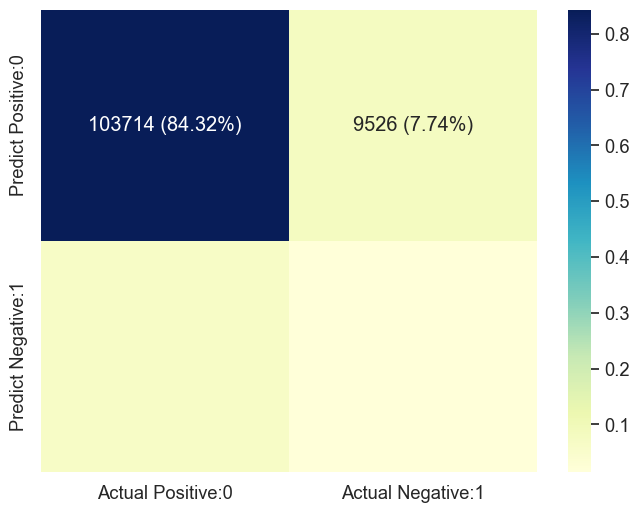

In [131]:
# Suppose cm is your confusion matrix
cm = confusion_matrix(y_test, y_pred1)

# Calculate the total number of samples
total_samples = cm.sum()

# Calculate percentages
cm_percentage = cm.astype('float') / total_samples  # Normalize by dividing by the total number of samples

# Create a DataFrame from the percentage matrix
cm_percentage_df = pd.DataFrame(data=cm_percentage, columns=['Actual Positive:0', 'Actual Negative:1'],
                                index=['Predict Positive:0', 'Predict Negative:1'])

# Create an empty DataFrame to store both number and percentage annotations
annotations = pd.DataFrame(columns=['Actual Positive:0', 'Actual Negative:1'],
                            index=['Predict Positive:0', 'Predict Negative:1'])

# Loop through the confusion matrix and add both number and percentage annotations
for i in range(2):
    for j in range(2):
        annotations.iloc[i, j] = f"{cm[i, j]} ({cm_percentage_df.iloc[i, j]*100:.2f}%)"

# Set up the figure
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size

# Create the heatmap with annotations
sns.heatmap(cm_percentage_df, annot=annotations, fmt="", cmap='YlGnBu')

plt.show()
#Ce code prend en compte le nombre total d'individus dans la variable total_samples et calcule le pourcentage en divisant par ce nombre total. Les annotations comprennent à la fois le nombre et le pourcentage. Le format d'affichage des pourcentages peut également être ajusté selon vos préférences.


In [132]:
grid_search_model = grid_search.best_estimator_
y_pred_grid = grid_search_model.predict(X_test)
 
# Print classification report for the Grid Search model
print("Grid Search - Classification Report:")
print(classification_report(y_test, y_pred1))

Grid Search - Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92    113240
           1       0.16      0.19      0.18      9763

    accuracy                           0.86    123003
   macro avg       0.55      0.55      0.55    123003
weighted avg       0.87      0.86      0.86    123003



In [133]:
# Étape 2 : Calculez les scores en utilisant votre métrique personnalisée
thresholds = np.arange(0.1, 0.9, 0.1)  # Vous pouvez ajuster l'intervalle
best_score = float('-inf')  # Initialisez le meilleur score à négatif infini
best_threshold = 0

In [134]:
for threshold in thresholds:
    y_pred = (y_pred_proba1_test  > threshold).astype(int)
    current_score = abs(custom_score(y_test, y_pred, false_positive_cost=1, false_negative_cost=10))
    print(f"threshold {threshold} score {current_score}")

    if current_score > best_score:
        best_score = current_score
        best_threshold = threshold

# Étape 3 : Sélectionnez le seuil optimal
print("Meilleur seuil (score personnalisé) : {:.2f}".format(best_threshold))

threshold 0.1 score 1132400
threshold 0.2 score 1130403
threshold 0.30000000000000004 score 896598
threshold 0.4 score 441859
threshold 0.5 score 103163
threshold 0.6000000000000001 score 28949
threshold 0.7000000000000001 score 10445
threshold 0.8 score 9763
Meilleur seuil (score personnalisé) : 0.10


In [135]:
# Enregistrement de l'exécution avec MLflow
with mlflow.start_run() as run:
    # Création et entraînement du modèle CatBoost
    catboost_model_smote = CatBoostClassifier(**best_params)
    catboost_model_smote.fit(X_train_resampled, y_train_resampled)
    
    # Prédiction et calcul de l'AUC sur les données de test
    y_pred_proba4_test = catboost_model_smote.predict_proba(X_test)[:, 1]
    auc_test4 = roc_auc_score(y_test, y_pred_proba4_test)
    current_score = abs(custom_score(y_test, y_pred, false_positive_cost=1, false_negative_cost=10))
    
    # Calcul de la courbe ROC pour les données de test
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba4_test)
    # Enregistrement de la courbe ROC dans MLflow
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_test4)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Test)')
    plt.legend(loc="lower right")
    
    # Enregistrement des métriques dans MLflow
    mlflow.log_param("model", "CatBoostClassifier_smote")
    mlflow.log_metric("AUC_test_CatBoostClassifier_smote", auc_test)
    mlflow.log_metric("score_test_CatBoostClassifier_smote", current_score)
    
    # Enregistrement du modèle CatBoost dans MLflow
    mlflow.catboost.log_model(catboost_model_smote, "catboost-model-smote")
    
    # Enregistrement de la courbe ROC en tant qu'artefact
    roc_fig_cat = "ROC_curve_test1.png"
    plt.savefig(roc_fig_cat)
    mlflow.log_artifact(roc_fig_cat)
    plt.close()
    
    # Log the sklearn model and register as version 1
    mlflow.sklearn.log_model(
        sk_model=catboost_model1 ,
        artifact_path="sklearn-catboostmodel-smote",
        #signature=signature,
        registered_model_name="sk-learn-CatBoostClassifiersmote-model",
    )

0:	learn: 0.6906054	total: 42ms	remaining: 4.16s
1:	learn: 0.6881190	total: 79.8ms	remaining: 3.91s
2:	learn: 0.6856848	total: 114ms	remaining: 3.7s
3:	learn: 0.6833164	total: 151ms	remaining: 3.63s
4:	learn: 0.6809841	total: 187ms	remaining: 3.55s
5:	learn: 0.6787149	total: 226ms	remaining: 3.54s
6:	learn: 0.6764864	total: 274ms	remaining: 3.64s
7:	learn: 0.6742801	total: 320ms	remaining: 3.68s
8:	learn: 0.6721383	total: 365ms	remaining: 3.69s
9:	learn: 0.6700453	total: 409ms	remaining: 3.68s
10:	learn: 0.6681759	total: 450ms	remaining: 3.64s
11:	learn: 0.6661327	total: 494ms	remaining: 3.63s
12:	learn: 0.6641457	total: 537ms	remaining: 3.59s
13:	learn: 0.6623958	total: 574ms	remaining: 3.52s
14:	learn: 0.6604442	total: 613ms	remaining: 3.47s
15:	learn: 0.6585443	total: 651ms	remaining: 3.42s
16:	learn: 0.6564728	total: 694ms	remaining: 3.39s
17:	learn: 0.6548195	total: 752ms	remaining: 3.42s
18:	learn: 0.6530244	total: 806ms	remaining: 3.44s
19:	learn: 0.6510344	total: 860ms	remainin

Registered model 'sk-learn-CatBoostClassifiersmote-model' already exists. Creating a new version of this model...
2023/12/12 14:27:46 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: sk-learn-CatBoostClassifiersmote-model, version 4
Created version '4' of model 'sk-learn-CatBoostClassifiersmote-model'.


XGBOOST

In [136]:
X = df_filled.drop('TARGET', axis=1)
y = df_filled['TARGET']

In [137]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [138]:
smote = SMOTE(sampling_strategy=0.75)

In [139]:
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [140]:
X_test

,index,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
486583,179072,307510,1,0,1,0,247500.0,640080.0,29839.5,450000.0,...,0,0,0,0,0,0,0.386670,247500.0,0.120564,0.046618
279850,279850,424218,1,0,0,0,157500.0,288873.0,17802.0,238500.0,...,0,0,1,0,1,0,0.545222,157500.0,0.113029,0.061626
281214,281214,425787,1,0,0,0,202500.0,490495.5,27517.5,454500.0,...,0,0,0,0,0,0,0.412848,101250.0,0.135889,0.056101
317509,9998,111632,1,0,1,0,360000.0,348264.0,27643.5,315000.0,...,0,0,0,0,0,0,1.033699,180000.0,0.076787,0.079375
533724,226213,362009,1,0,1,0,171000.0,162000.0,15912.0,162000.0,...,0,0,0,0,0,0,1.055556,85500.0,0.093053,0.098222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408916,101405,217729,1,1,0,2,270000.0,585000.0,21010.5,585000.0,...,0,0,1,0,1,0,0.461538,67500.0,0.077817,0.035915
342566,35055,140613,1,0,1,0,180000.0,360000.0,18508.5,360000.0,...,0,0,0,0,0,0,0.500000,90000.0,0.102825,0.051412
42424,42424,149104,1,0,0,0,117000.0,868797.0,34456.5,702000.0,...,0,0,0,0,0,0,0.134669,58500.0,0.294500,0.039660
221844,221844,356991,1,0,1,0,90000.0,134316.0,15939.0,126000.0,...,0,0,0,0,0,0,0.670062,45000.0,0.177100,0.118668


In [141]:
# Créez un modèle XGBoost Classifier
xgb_model = xgb.XGBClassifier()

In [142]:
# Définissez la grille de paramètres à tester
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300]
}

In [143]:
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, n_jobs=-1, scoring=custom_scorer)

In [144]:
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             scoring=make_scorer(custom_score, greater_is_better=False, false_positive_cost=1, false_negative_cost=10))

In [145]:
best_params = grid_search.best_params_
print("Meilleurs hyperparamètres :", best_params)

Meilleurs hyperparamètres : {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100}


In [146]:
xgb1_model =  xgb.XGBClassifier(**best_params)

In [147]:
xgb1_model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [148]:
y_pred_proba2_test = xgb1_model.predict_proba(X_test)[:, 1]  # Probabilité de la classe positive

In [149]:
y_pred_proba2_train = xgb1_model.predict_proba(X_train)[:, 1]  # Probabilité de la classe positive

In [150]:
y_pred2 = xgb1_model.predict(X_test)

In [151]:
auc_train = roc_auc_score(y_train, y_pred_proba2_train)
print("AUC_train:", auc_train)

AUC_train: 0.661749001763958


In [152]:
auc_test = roc_auc_score(y_test, y_pred_proba2_test)
print("AUC_test:", auc_test)

AUC_test: 0.6607876792124535


In [153]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred2)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[104557   8683]
 [  8001   1762]]

True Positives(TP) =  104557

True Negatives(TN) =  1762

False Positives(FP) =  8683

False Negatives(FN) =  8001


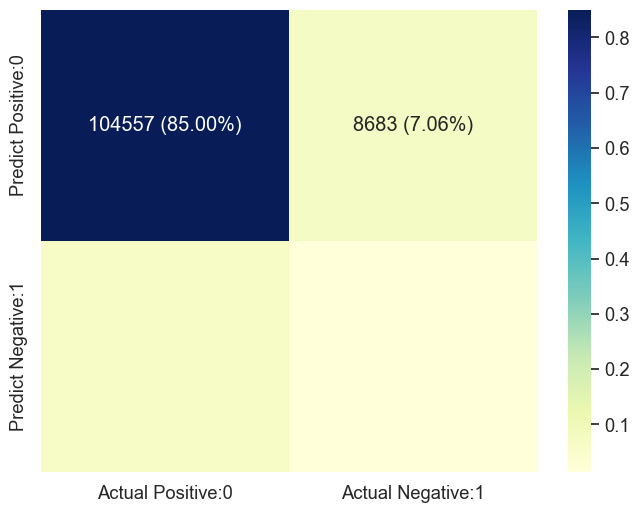

In [154]:
# Suppose cm is your confusion matrix
cm = confusion_matrix(y_test, y_pred2)

# Calculate the total number of samples
total_samples = cm.sum()

# Calculate percentages
cm_percentage = cm.astype('float') / total_samples  # Normalize by dividing by the total number of samples

# Create a DataFrame from the percentage matrix
cm_percentage_df = pd.DataFrame(data=cm_percentage, columns=['Actual Positive:0', 'Actual Negative:1'],
                                index=['Predict Positive:0', 'Predict Negative:1'])

# Create an empty DataFrame to store both number and percentage annotations
annotations = pd.DataFrame(columns=['Actual Positive:0', 'Actual Negative:1'],
                            index=['Predict Positive:0', 'Predict Negative:1'])

# Loop through the confusion matrix and add both number and percentage annotations
for i in range(2):
    for j in range(2):
        annotations.iloc[i, j] = f"{cm[i, j]} ({cm_percentage_df.iloc[i, j]*100:.2f}%)"

# Set up the figure
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size

# Create the heatmap with annotations
sns.heatmap(cm_percentage_df, annot=annotations, fmt="", cmap='YlGnBu')

plt.show()
#Ce code prend en compte le nombre total d'individus dans la variable total_samples et calcule le pourcentage en divisant par ce nombre total. Les annotations comprennent à la fois le nombre et le pourcentage. Le format d'affichage des pourcentages peut également être ajusté selon vos préférences.


In [155]:
grid_search_model = grid_search.best_estimator_
y_pred_grid = grid_search_model.predict(X_test)
 
# Print classification report for the Grid Search model
print("Grid Search - Classification Report:")
print(classification_report(y_test, y_pred2))

Grid Search - Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93    113240
           1       0.17      0.18      0.17      9763

    accuracy                           0.86    123003
   macro avg       0.55      0.55      0.55    123003
weighted avg       0.87      0.86      0.87    123003



In [156]:
# Étape 2 : Calculez les scores en utilisant votre métrique personnalisée
thresholds = np.arange(0.1, 0.9, 0.1)  # Vous pouvez ajuster l'intervalle
best_score = float('-inf')  # Initialisez le meilleur score à négatif infini
best_threshold = 0

In [157]:
for threshold in thresholds:
    y_pred = (y_pred_proba2_test  > threshold).astype(int)
    current_score = abs(custom_score(y_test, y_pred, false_positive_cost=1, false_negative_cost=10))
    print(f"threshold {threshold} score {current_score}")

    if current_score > best_score:
        best_score = current_score
        best_threshold = threshold

# Étape 3 : Sélectionnez le seuil optimal
print("Meilleur seuil (score personnalisé) : {:.2f}".format(best_threshold))

threshold 0.1 score 1132400
threshold 0.2 score 1129558
threshold 0.30000000000000004 score 733305
threshold 0.4 score 317538
threshold 0.5 score 94831
threshold 0.6000000000000001 score 15863
threshold 0.7000000000000001 score 9793
threshold 0.8 score 9763
Meilleur seuil (score personnalisé) : 0.10


In [158]:
with mlflow.start_run() as run:
    # Création et entraînement du modèle XGBoost
    xgb_model_smote = xgb.XGBClassifier(**best_params)
    xgb_model_smote.fit(X_train_resampled, y_train_resampled)
    
    # Prédiction et calcul de l'AUC sur les données de test
    y_pred_proba5_test = xgb_model_smote.predict_proba(X_test)[:, 1]
    auc_test5 = roc_auc_score(y_test, y_pred_proba5_test)
    current_score = abs(custom_score(y_test, y_pred, false_positive_cost=1, false_negative_cost=10))
    
    # Calcul de la courbe ROC pour les données de test
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba5_test)
    
    # Enregistrement de la courbe ROC dans MLflow
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_test5)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Test)')
    plt.legend(loc="lower right")
    
    # Enregistrement des métriques dans MLflow
    mlflow.log_param("model", "XGBoostClassifier_smote")
    mlflow.log_metric("AUC_test_XGBoostClassifier_smote", auc_test5)
    mlflow.log_metric("score_test_XGBoostClassifier_smote", current_score)
    
    # Enregistrement du modèle XGBoost dans MLflow
    mlflow.xgboost.log_model(xgb_model_smote, "xgboost-model-smote")
    
    # Enregistrement de la courbe ROC en tant qu'artefact
    roc_fig_xgb = "ROC_curve_test_xgb.png"
    plt.savefig(roc_fig_xgb)
    mlflow.log_artifact(roc_fig_xgb)
    plt.close()

      # Log the sklearn model and register as version 1
    mlflow.sklearn.log_model(
        sk_model=xgb_model ,
        artifact_path="sklearn-xgb_model_smote",
        #signature=signature,
        registered_model_name="sk-learn-xgb_model_smote-model",
    )

2023/12/12 14:48:19 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/29/yn5s79ss3h190zqtwzzqyrh00000gn/T/tmpjpsw1bgh/model, flavor: xgboost), fall back to return ['xgboost==2.0.0']. Set logging level to DEBUG to see the full traceback.
Registered model 'sk-learn-xgb_model_smote-model' already exists. Creating a new version of this model...
2023/12/12 15:04:28 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: sk-learn-xgb_model_smote-model, version 4
Created version '4' of model 'sk-learn-xgb_model_smote-model'.


RANDOMFOREST

In [38]:
X = df_filled.drop('TARGET', axis=1)
y = df_filled['TARGET']

In [39]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [40]:
smote = SMOTE(sampling_strategy=0.75)

In [41]:
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [42]:
# Créez un modèle RandomForest Classifier
rf_model = RandomForestClassifier()

In [43]:
hyperparameters = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10]}

In [44]:
grid_search = GridSearchCV(estimator=rf_model, param_grid=hyperparameters, scoring=custom_scorer, cv=3)

In [45]:
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 5, 10],
                         'n_estimators': [10, 50, 100]},
             scoring=make_scorer(custom_score, greater_is_better=False, false_positive_cost=1, false_negative_cost=10))

In [46]:
best_params = grid_search.best_params_
print("Meilleurs hyperparamètres :", best_params)

Meilleurs hyperparamètres : {'max_depth': 5, 'n_estimators': 50}


In [47]:
rf1_model =  RandomForestClassifier(**best_params)

In [48]:
rf1_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=5, n_estimators=50)

In [49]:
y_pred_proba3_test = rf1_model.predict_proba(X_test)[:, 1]  # Probabilité de la classe positive

In [50]:
y_pred_proba3_train = rf1_model.predict_proba(X_train)[:, 1]  # Probabilité de la classe positive

In [51]:
y_pred3 = rf1_model.predict(X_test)

In [52]:
auc_train = roc_auc_score(y_train, y_pred_proba3_train)
print("AUC_train:", auc_train)

AUC_train: 0.6408962324332356


In [53]:
auc_test = roc_auc_score(y_test, y_pred_proba3_test)
print("AUC_test:", auc_test)

AUC_test: 0.6404744660571402


In [54]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred3)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[106428   6812]
 [  8327   1436]]

True Positives(TP) =  106428

True Negatives(TN) =  1436

False Positives(FP) =  6812

False Negatives(FN) =  8327


In [55]:
grid_search_model = grid_search.best_estimator_
y_pred_grid = grid_search_model.predict(X_test)
 
# Print classification report for the Grid Search model
print("Grid Search - Classification Report:")
print(classification_report(y_test, y_pred3))

Grid Search - Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93    113240
           1       0.17      0.15      0.16      9763

    accuracy                           0.88    123003
   macro avg       0.55      0.54      0.55    123003
weighted avg       0.87      0.88      0.87    123003



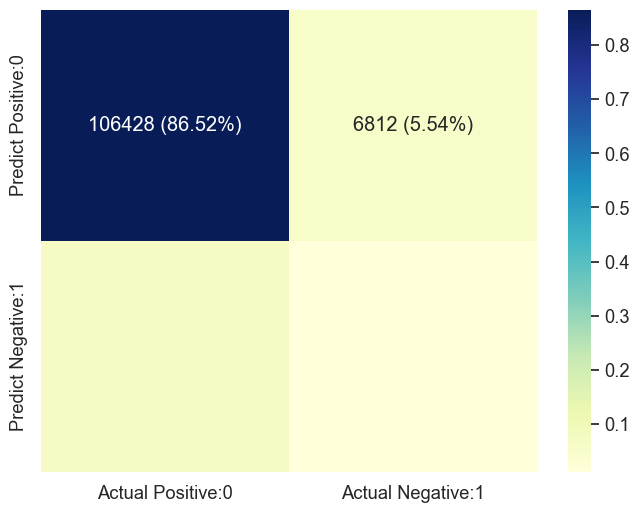

In [56]:
# Suppose cm is your confusion matrix
cm = confusion_matrix(y_test, y_pred3)

# Calculate the total number of samples
total_samples = cm.sum()

# Calculate percentages
cm_percentage = cm.astype('float') / total_samples  # Normalize by dividing by the total number of samples

# Create a DataFrame from the percentage matrix
cm_percentage_df = pd.DataFrame(data=cm_percentage, columns=['Actual Positive:0', 'Actual Negative:1'],
                                index=['Predict Positive:0', 'Predict Negative:1'])

# Create an empty DataFrame to store both number and percentage annotations
annotations = pd.DataFrame(columns=['Actual Positive:0', 'Actual Negative:1'],
                            index=['Predict Positive:0', 'Predict Negative:1'])

# Loop through the confusion matrix and add both number and percentage annotations
for i in range(2):
    for j in range(2):
        annotations.iloc[i, j] = f"{cm[i, j]} ({cm_percentage_df.iloc[i, j]*100:.2f}%)"

# Set up the figure
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size

# Create the heatmap with annotations
sns.heatmap(cm_percentage_df, annot=annotations, fmt="", cmap='YlGnBu')

plt.show()
#Ce code prend en compte le nombre total d'individus dans la variable total_samples et calcule le pourcentage en divisant par ce nombre total. Les annotations comprennent à la fois le nombre et le pourcentage. Le format d'affichage des pourcentages peut également être ajusté selon vos préférences.


In [57]:
# Étape 2 : Calculez les scores en utilisant votre métrique personnalisée
thresholds = np.arange(0.1, 0.9, 0.1)  # Vous pouvez ajuster l'intervalle
best_score = float('-inf')  # Initialisez le meilleur score à négatif infini
best_threshold = 0

In [58]:
for threshold in thresholds:
    y_pred = (y_pred_proba3_test  > threshold).astype(int)
    current_score = abs(custom_score(y_test, y_pred, false_positive_cost=1, false_negative_cost=10))
    print(f"threshold {threshold} score {current_score}")

    if current_score > best_score:
        best_score = current_score
        best_threshold = threshold

# Étape 3 : Sélectionnez le seuil optimal
print("Meilleur seuil (score personnalisé) : {:.2f}".format(best_threshold))

threshold 0.1 score 1132400
threshold 0.2 score 1086096
threshold 0.30000000000000004 score 750111
threshold 0.4 score 339596
threshold 0.5 score 76447
threshold 0.6000000000000001 score 11589
threshold 0.7000000000000001 score 9763
threshold 0.8 score 9763
Meilleur seuil (score personnalisé) : 0.10


In [63]:
# Enregistrement de l'exécution avec MLflow
with mlflow.start_run() as run:
    # Création et entraînement du modèle RandomForest
    rf_model_smote = RandomForestClassifier(**best_params)
    rf_model_smote.fit(X_train_resampled, y_train_resampled)
    
    # Prédiction et calcul de l'AUC sur les données de test
    y_pred_proba6_test = rf_model_smote.predict_proba(X_test)[:, 1]
    auc_test6 = roc_auc_score(y_test, y_pred_proba6_test)
    current_score = abs(custom_score(y_test, y_pred, false_positive_cost=1, false_negative_cost=10))
    
    # Calcul de la courbe ROC pour les données de test
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba6_test)
    # Enregistrement de la courbe ROC dans MLflow
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_test6)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Test)')
    plt.legend(loc="lower right")
    
    # Enregistrement des métriques dans MLflow
    mlflow.log_param("model", " rf_model_smote")
    mlflow.log_metric("AUC_test_ rf_model_smote", auc_test6)
    mlflow.log_metric("score_test_ rf_model_smote", current_score)
    
    # Enregistrement du modèle RandomForest dans MLflow
    mlflow.sklearn.log_model(
        sk_model=rf_model_smote,
        artifact_path="rf_model_smote",
        registered_model_name="rf_model_smote"
    )
    
    # Enregistrement de la courbe ROC en tant qu'artefact
    roc_fig_rf = "ROC_curve_test_rf.png"
    plt.savefig(roc_fig_rf)
    mlflow.log_artifact(roc_fig_rf)
    plt.close()
    
    # Enregistrement d'un autre modèle RandomForest dans MLflow (juste à titre d'exemple)
    mlflow.sklearn.log_model(
        sk_model=rf_model_smote,
        artifact_path="random-forest-model",
        registered_model_name="sk-learn-random-forest-model",
    )

Successfully registered model 'rf_model_smote'.
2023/12/13 10:23:32 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: rf_model_smote, version 1
Created version '1' of model 'rf_model_smote'.
Registered model 'sk-learn-random-forest-model' already exists. Creating a new version of this model...
2023/12/13 10:23:34 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: sk-learn-random-forest-model, version 6
Created version '6' of model 'sk-learn-random-forest-model'.


Après évaluation de tous les modèles avec leurs métriques respectives, nous avons choisi le XGBoost avec SMOTE comme meilleur modèle de prédiction du score.

## FEATURE IMPORTANCE GLOBALE

Pour voir les features qui ont le plus influencé notre prédiction , nous allons faire la feature importance globale avec SHAP. La feature importance globale calculée avec SHAP est un outil essentiel pour comprendre et expliquer les prédictions des modèles d'apprentissage automatique, ce qui aide à la confiance et à l'interprétabilité des modèles.

Text(0.5, 1.0, 'Feature Importance globale')

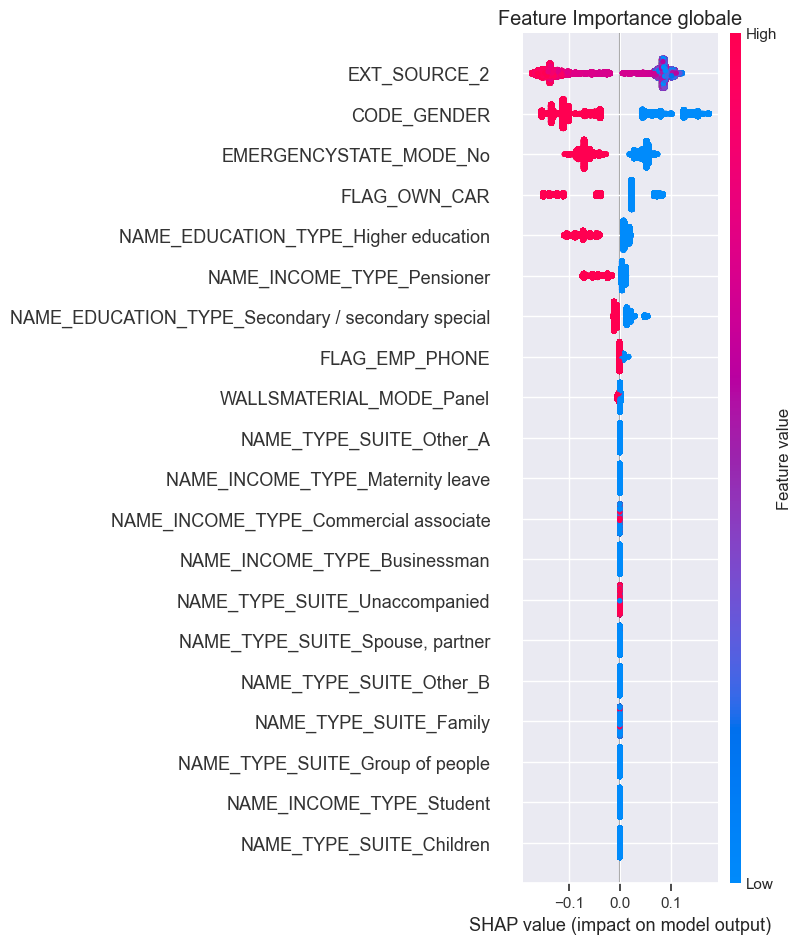

In [186]:
explainer = shap.TreeExplainer(xgb1_model)
shap_values = explainer.shap_values(X_test)

# Afficher les summary plots des SHAP values
shap.summary_plot(shap_values, X_test, show=False)
plt.title('Feature Importance globale')

Pour permettre de faciliter la lecture de nos données dans le dashboard streamlit, nous n'allons travailler que sur 1000 colonnes.

Avec 1000 échantillons

In [187]:
X = df_filled.drop('TARGET', axis=1)
y = df_filled['TARGET']

In [188]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

In [189]:
df_smote = pd.DataFrame(X_smote, columns=X.columns)
df_smote['TARGET'] = y_smote

In [190]:
df_select = df_smote.head(1000)

In [191]:
X = df_select.drop('TARGET', axis=1)
y = df_select['TARGET']

In [192]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [193]:
xgb_model = XGBClassifier(
    learning_rate=0.01,  # Taux d'apprentissage
    n_estimators=100,   # Nombre d'arbres (itérations)
    max_depth=4,       # Profondeur maximale de l'arbre
    objective='binary:logistic',  # Problème de classification binaire
    use_label_encoder=False,      # Désactiver l'encodage automatique des étiquettes
)

In [194]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [195]:
X_train

,index,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
29,29,100034,0,0,0,0,90000.0,180000.0,9000.0,180000.0,...,0,1,0,0,1,0,0.500000,90000.0,0.100000,0.050000
535,535,100619,1,0,1,0,99000.0,364896.0,13653.0,315000.0,...,0,0,1,0,1,0,0.271310,99000.0,0.137909,0.037416
695,695,100804,1,0,0,2,157500.0,407727.0,32341.5,333000.0,...,0,0,1,0,1,0,0.386288,39375.0,0.205343,0.079321
557,557,100643,1,0,0,0,90000.0,755190.0,29677.5,675000.0,...,0,1,0,0,1,0,0.119175,90000.0,0.329750,0.039298
836,836,100956,1,0,0,0,157500.0,587623.5,32940.0,544500.0,...,0,0,0,0,1,0,0.268029,78750.0,0.209143,0.056056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,106,100125,1,0,1,0,126000.0,263686.5,26208.0,238500.0,...,0,0,0,0,0,0,0.477840,63000.0,0.208000,0.099391
270,270,100313,1,0,0,0,87750.0,1206954.0,35419.5,945000.0,...,0,0,0,0,0,0,0.072704,43875.0,0.403641,0.029346
860,860,100985,0,1,0,1,225000.0,1574532.0,62572.5,1350000.0,...,0,0,1,0,1,0,0.142900,75000.0,0.278100,0.039740
435,435,100502,1,1,0,0,202500.0,485640.0,41674.5,450000.0,...,0,0,1,0,1,0,0.416976,101250.0,0.205800,0.085814


In [196]:
y_pred_class = xgb_model.predict_proba(X_test)[:, 1]  # Probabilité de la classe positive

In [197]:
y_pred_classes = xgb_model.predict_proba(X)[:, 1] 

In [198]:
df_select['score'] = y_pred_classes

In [199]:
df_select.head(100)

,index,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,TARGET,score
0,0,100002,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,1,0,1,0,0.498036,202500.0,0.121978,0.060749,1,0.303102
1,1,100003,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,1,0,0.208736,135000.0,0.132217,0.027598,0,0.078365
2,2,100004,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.500000,67500.0,0.100000,0.050000,0,0.075252
3,3,100006,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0.431748,67500.0,0.219900,0.094941,0,0.072133
4,4,100007,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.236842,121500.0,0.179963,0.042623,0,0.096765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,100113,0,1,1,0,76500.0,135000.0,6696.0,135000.0,...,0,0,0,0,0.566667,76500.0,0.087529,0.049600,0,0.087189
96,96,100114,1,0,0,0,135000.0,284400.0,22599.0,225000.0,...,0,0,0,0,0.474684,135000.0,0.167400,0.079462,0,0.129994
97,97,100115,1,0,1,0,90000.0,315000.0,14683.5,315000.0,...,0,0,1,0,0.285714,45000.0,0.163150,0.046614,0,0.095411
98,98,100116,1,0,0,0,243000.0,900000.0,32017.5,900000.0,...,1,0,1,0,0.270000,121500.0,0.131759,0.035575,0,0.073064


In [200]:
auc_test = roc_auc_score(y_test, y_pred_class)
print("AUC_test:", auc_test)

AUC_test: 0.692154255319149


Nous allons ensuite télécharger le fichier .csv.

In [201]:
X.to_csv('df_select.csv', index=False)

In [202]:
X.to_json('df_select.json', orient='records', lines=True)

In [203]:
len(X.columns)

193

In [204]:
X

,index,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,0,100002,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,0,0,1,0,1,0,0.498036,202500.0,0.121978,0.060749
1,1,100003,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,1,0,0.208736,135000.0,0.132217,0.027598
2,2,100004,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0,0,0.500000,67500.0,0.100000,0.050000
3,3,100006,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0,0,0.431748,67500.0,0.219900,0.094941
4,4,100007,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0,0,0.236842,121500.0,0.179963,0.042623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,101152,1,0,1,0,112500.0,495985.5,17946.0,409500.0,...,0,0,0,1,1,0,0.226821,112500.0,0.159520,0.036183
996,996,101153,1,0,0,0,225000.0,1113840.0,57001.5,900000.0,...,0,0,0,1,1,0,0.202004,225000.0,0.253340,0.051176
997,997,101154,1,1,0,0,144000.0,517536.0,28206.0,432000.0,...,0,0,0,0,0,0,0.278242,72000.0,0.195875,0.054501
998,998,101155,0,0,0,0,315000.0,1288350.0,37800.0,1125000.0,...,0,1,0,0,1,0,0.244499,157500.0,0.120000,0.029340


Ensuite, nous allons télécharger également le modèle avec pickle.

In [205]:
import joblib
import streamlit as st

In [206]:
#Sauvegarde du modèle
pickle.dump(xgb_model, open("./xgb_model.pkl", "wb"))

Une fois cela fait, nous allons faire la feature importance locale c'est-à-dire les features qui influent sur le score pour un client donné.

## Feature importance locale

In [207]:
shap.initjs()

In [208]:
X_numpy = np.array(X)

In [209]:
explainer = shap.Explainer(xgb_model, X_numpy)

In [210]:
shap_values = explainer.shap_values(X_numpy)

In [211]:
#Supposons que 'i' est l'index de la ligne que vous souhaitez visualiser
i = 277  # Vous pouvez utiliser n'importe quel autre index

#Récupérez la valeur de l'index à partir de votre DataFrame
selected_index = df_select.loc[i, 'index']

# Utilisez cette valeur pour accéder aux bonnes lignes dans shap_values et X
shap.force_plot(explainer.expected_value, shap_values[selected_index], features=X.iloc[selected_index], feature_names=X.columns)

<Figure size 640x480 with 0 Axes>

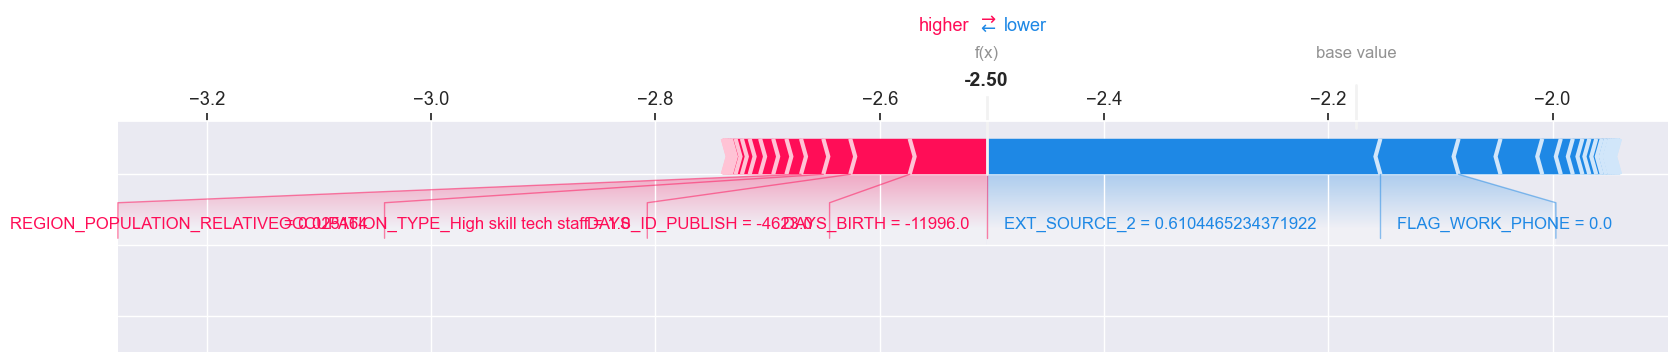

In [212]:
def feature_importance(xgb_model, X_numpy):

    explainer = shap.TreeExplainer(xgb_model)
    shap_values = explainer.shap_values(X_numpy)
    shap.initjs()

    return shap.force_plot(explainer.expected_value, shap_values[selected_index], features=X.iloc[selected_index], feature_names=X.columns, matplotlib=True,show=False)


plt.clf()
#data_for_prediction = X_numpy.iloc[2,:].astype(float)
feature_importance(xgb_model, X_numpy)
plt.savefig("gg.png",dpi=150, bbox_inches='tight')

In [213]:
# Loading model to compare the results
model = pickle.load(open('/Users/soneitaraherimalala/Desktop/P7/xgb_model.pkl','rb'))


In [214]:
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [1]:
pip install --upgrade matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [73]:
pip install streamlit


Note: you may need to restart the kernel to use updated packages.


In [74]:
pip install streamlit-shap

Note: you may need to restart the kernel to use updated packages.


In [75]:
from streamlit_shap import st_shap

P7.py

Le code souvent permet d'avoir le dasnboard ave streamlit à partir de l'API du score. 

In [ ]:
import pandas as pd
import streamlit as st
import requests
import joblib
import shap
import numpy as np
import xgboost
from xgboost import XGBClassifier, plot_importance
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import plotly.express as px
from streamlit_shap import st_shap



# Définir l'URL de votre API Flask
api_url = 'http://127.0.0.1:5000/predict_score'
#Chargez votre modèle XGBoost
model = pickle.load(open('/Users/soneitaraherimalala/Desktop/P7/xgb_model.pkl', 'rb'))
def main():
    st.title('Dashboard')
    
    # Charger le DataFrame contenant les informations des clients
    df_select = pd.read_csv('/Users/soneitaraherimalala/Desktop/P7/df_select.csv')
    #st.subheader(df_filled)

    # Demandez à l'utilisateur de taper le numéro du client
    selected_client_id = st.text_input("Tapez le numéro du client", value="")

    # Afficher le numéro du client et la décision de crédit s'il existe

    if selected_client_id:

        selected_client_id = int(selected_client_id)
        if selected_client_id in df_select['SK_ID_CURR'].values:
            # Récupérez les informations du client en fonction du numéro du client
            client_info = df_select[df_select['SK_ID_CURR'] == selected_client_id].iloc[0]

            # Affichez les détails du client
            st.subheader("Détails du client")
            st.write(f"N° Client : {selected_client_id}")

            # Envoyez une requête à l'API pour obtenir le score du client
            api_data = {'data': selected_client_id}  # Utilisez la même clé que dans votre code Flask
            response = requests.post(api_url, json=api_data)
            # Vérifiez si la requête a réussi avant de traiter les résultats
            if response.status_code == 200:
                st.write(response.text)
    
            # Obtenez le score prédit
            prediction = response.json()

            # Accédez à la liste des prédictions sous la clé 'prediction'
            prediction_list = prediction.get('prediction', [])

            # Obtenez le premier élément de la liste, ou None s'il est vide
            predicted_score = prediction_list[0] if prediction_list else None

            # Tentez de convertir la valeur du score en float
            try:
                predicted_score = float(predicted_score)
            except (TypeError, ValueError):
                    pass  # Laissez la valeur inchangée si la conversion échoue

            # Vérifiez si la valeur du score n'est pas None et est de type numérique
            if predicted_score is not None and isinstance(predicted_score, (int, float)):
                #Classez le client en fonction du score
                if predicted_score < 0.1:
                    st.write("Classe : 0 (Crédit accordé)")
                else:
                    st.write("Classe : 1 (Crédit refusé)")
                    
            if predicted_score is not None and isinstance(predicted_score, (int, float)):
                if predicted_score < 0.1:
                    df_select['Classe'] = 0
                else:
                    df_select['Classe'] = 1
                #st.write(f"Score : {predicted_score}")
                #st.write("Classe :", df_select['Classe'].values[0])
                
            st.write(f"Score : {predicted_score}")
         
           # Seuil
            seuil = 0.8

            # Couleur de la barre de progression (vert si le score est inférieur au seuil, rouge sinon)
            if predicted_score < seuil:
                couleur = 'green'
            else:
                couleur = 'red'

    # Créez la barre de progression
            st.subheader("Barre de progression du score")
            st.progress(predicted_score)

        # Ajoutez une indication du seuil
            st.write(f"Seuil : {seuil}")
            # Calcul de l'importance locale avec SHAP
            st.subheader("Importance locale des features")
            #shap.initjs() 
            X_numpy = df_select.to_numpy()
            explainer = shap.Explainer(model, X_numpy)
            numpy_index = df_select[df_select['SK_ID_CURR'] == selected_client_id].index.values[0]

# Calculer les valeurs SHAP pour l'index spécifié dans X_numpy
            shap_values = explainer.shap_values(X_numpy[numpy_index].reshape(1, -1))
            shap.initjs() 
# Créer le graphique SHAP pour la feature importance locale
            shap.force_plot(explainer.expected_value, shap_values, df_select.iloc[numpy_index], feature_names=df_select.columns)
            # Calculez les valeurs SHAP pour le client sélectionné
            #shap_values = explainer.shap_values(X_numpy[selected_client_id].reshape(1, -1))
            st_shap( shap.force_plot(explainer.expected_value, shap_values, df_select.iloc[numpy_index], feature_names=df_select.columns))
            # Calculez les valeurs SHAP pour le client sélectionné
            #shap_values = explainer.shap_values(X_numpy[selected_client_id].reshape(1, -1))

            #shap.initjs()  # Assurez-vous d'appeler cette fonction pour activer JavaScript pour les graphiques SHAP
            
         
            
            #Feature Importance globale
            st.subheader("Importance globale des features")
            explainer = shap.Explainer(model, df_select)
            shap_values = explainer(df_select)

            #st_shap(shap.plots.waterfall(shap_values[0]), height=300)
            st_shap(shap.plots.beeswarm(shap_values), height=300)
            
            
            st.title("Visualisation des fonctionnalités")

            # Sélectionnez la fonctionnalité dans une liste déroulante
            feature1 = st.selectbox("Sélectionnez une fonctionnalité :", df_select.columns[:-1], key="feature1")
           
            # Affichez la distribution de la fonctionnalité selon les classes (barplot)
            st.subheader(f"Distribution de {feature1} selon les classes")
           
            # Créez une figure et un axe
            fig, ax = plt.subplots(figsize=(8, 6))

            # Utilisez sns.histplot pour créer le graphique de distribution
            sns.histplot(data=df_select, x=feature1, hue=df_select['Classe'], multiple="stack", kde=True, ax=ax)

            # Affichez le graphique dans Streamlit en utilisant st.pyplot(fig)
            st.pyplot(fig)


            # Affichez le positionnement de la valeur du client sur la fonctionnalité sélectionnée (scatterplot)
            st.subheader(f"Positionnement de la valeur du client sur {feature1}")
            # Ajoutez ici le code pour afficher le scatterplot

    # Affichez les informations sur la valeur sélectionnée
            # Affichez les informations sur la valeur sélectionnée
            selected_value1 = st.slider(
                f"Sélectionnez la valeur de {feature1}",
                float(df_select[feature1].min()),
                float(df_select[feature1].max()),
                float(df_select[feature1].mean()), key="feature1_slider"
                )
            st.write(f"Vous avez sélectionné la valeur {selected_value1} pour {feature1}")
            # Affichez la distribution de la première fonctionnalité selon les classes (barplot)
            
            # Sélectionnez la deuxième fonctionnalité dans une liste déroulante
            feature2 = st.selectbox("Sélectionnez une fonctionnalité :", df_select.columns[:-1], key="feature2")
            st.subheader(f"Distribution de {feature2} selon les classes")

            
            # Utilisez plt.figure() pour créer la figure au lieu de plt.subplots()
            fig2 = plt.figure(figsize=(8, 6))

            # Utilisez sns.histplot pour créer le graphique de distribution
            sns.histplot(data=df_select, x=feature2, hue='Classe', multiple="stack", kde=True)

            # Affichez le graphique dans Streamlit
            st.pyplot(fig2)
            
            st.subheader(f"Positionnement de la valeur du client sur {feature2}")
            selected_value2 = st.slider(
                f"Sélectionnez la valeur de {feature2}",
                float(df_select[feature2].min()),
                float(df_select[feature2].max()),
                float(df_select[feature2].mean()), key="feature2_slider"
                )
                    
            st.write(f"Vous avez sélectionné la valeur {selected_value2} pour {feature2}")
            # Affichez un graphique de dispersion (scatter plot) entre feature1 et feature2
            st.subheader(f"Analyse bivariée entre {feature1} et {feature2}")
            #df_select['score'] = prediction_list # R
            df_select['scores'] = model.predict(df_select[df_select.columns[:-1]])
            # Utilisez plt.figure() pour créer la figure
            fig3 = plt.figure(figsize=(8, 6))

            # Utilisez sns.scatterplot pour créer le graphique de dispersion avec une palette de couleurs
            sns.scatterplot(data=df_select, x=feature1, y=feature2, palette='coolwarm', legend='full')

            # Affichez le graphique dans Streamlit
            st.pyplot(fig3)
           
            
            
# Mettez à jour le scatterplot avec la ligne correspondant à la valeur sélectionnée
# Ajoutez ici le code pour mettre à jour le scatterplot en fonction de la valeur sélectionnée
        else:
            st.write("Le numéro du client n'existe pas dans le DataFrame.")
     
if __name__ == '__main__':
    main()
#Assurez-vous que api_url contient l'URL correcte de votre API, qui devrait être celle que vous avez configurée pour l'endpoint /predict_credit_score. Lorsque l'utilisateur entre le numéro du client, vous envoyez une requête à l'API, récupérez la prédiction et l'affichez dans votre dashboard Streamlit.

#N'oubliez pas de personnaliser davantage votre tableau de bord avec d'autres éléments et fonctionnalités selon vos besoins.








  




Score.py

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import numpy as np
from flask import Flask, request, jsonify
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pickle
import requests
import json
  
#app = Flask(__name__)
#model = pickle.load(open('/Users/soneitaraherimalala/xgb1_model.pkl', 'rb'))

#@app.route('/predict', methods=['POST'])
#def predict_credit_score():
    #data = request.get_json(force=True)
    #print(data)
    #prediction = model.predict_proba([[np.array(data['data'])]])
    #prediction = model.predict_proba([[np.array(data['data'])]])
    #output = prediction[0]
    #return jsonify(output)

#if __name__ == "__main__":
    #app.run(debug=True)
    
from flask import Flask, request, jsonify
import pickle
import pandas as pd
import numpy as np

app = Flask(__name__)

#Chargez votre modèle XGBoost
model = pickle.load(open('/Users/soneitaraherimalala/Desktop/P7/xgb_model.pkl', 'rb'))

# Chargez votre dataframe
df_select = pd.read_csv('/Users/soneitaraherimalala/Desktop/P7/df_select.csv')
print(df_select.columns)

@app.route('/predict_score', methods=['POST'])
def predict_score():
    print('test1')
    try:
        # Récupérez les données d'entrée au format JSON depuis la requête
        data = request.get_json(force=True)
        print(data)
       #Assurez-vous que les données reçues correspondent aux caractéristiques attendues par le modèle
        input_data = data.get('data')
        
        df_select[df_select['SK_ID_CURR']==input_data]
        print(input_data)
        if input_data is None:
            return jsonify({'error': 'Missing data field'})

# Sélectionnez les données du DataFrame correspondant à l'identifiant SK_ID_CURR spécifié
        client = df_select[df_select['SK_ID_CURR'] == input_data]

# Vérifiez si des données ont été trouvées pour l'identifiant donné
        if client.empty:
            return jsonify({'error': 'SK_ID_CURR not found'})

# Utilisez les données sélectionnées pour la prédiction
        y_pred_classes = model.predict_proba(client)[:, 1]  # Obtenez la probabilité de la classe positive

# Convertissez le tableau NumPy en une liste Python avant de le renvoyer dans la réponse JSON
        y_pred_classes_list = y_pred_classes.tolist()
# Retournez les scores prédits sous forme de liste
        return jsonify({'prediction': y_pred_classes_list})

    except Exception as e:
        return jsonify({'error': str(e)})

if __name__ == "__main__":
    app.run(debug=True)



In [ ]:
import unittest
from unittest.mock import patch
from io import StringIO
import sys
import os
import streamlit as st
import unittest
from unittest.mock import patch
from io import StringIO
import P7_script  # Importez le module P7_script correctement

class TestMyCode(unittest.TestCase):
    @patch('builtins.input', side_effect=["123"])
    def test_selected_client(self, mock_input):
        with patch('sys.stdout', new_callable=StringIO) as mock_stdout:
            P7_script.main()  # Assurez-vous que vous appelez la fonction appropriée de P7_script

        output = mock_stdout.getvalue()
        self.assertTrue("Score")  

    def test_nonexistent_client(self):
        with patch('sys.stdout', new_callable=StringIO) as mock_stdout:
            P7_script.main()  # Appelez la fonction appropriée de P7_script
       
        output = mock_stdout.getvalue()
        self.assertTrue("Le numéro du client n'existe pas dans le DataFrame." in output)

if __name__ == '__main__':
    unittest.main()


In [ ]:
# rsync -avz --exclude '.git/*' --exclude 'node_modules/*' --exclude '.env' "ssh -i test.pem" ./ ubuntu@35.180.190.64:/home/ubuntu/oc-P7/source
        # rsync -avz --exclude '.git/*' --exclude 'node_modules/*' --exclude '.env' "ssh -i test.pem" ./ ubuntu@${{ secrets.EC2_IP }}:/home/ubuntu/oc-P7/source
        rsync -avz -e "ssh -o StrictHostKeyChecking=no -i oc-P7linux.pem " --exclude '.git/*' --exclude 'node_modules/*' --exclude '.env'  ./ ubuntu@35.180.190.64:/home/ubuntu/deploy
  # ssh -i test.pem ubuntu@${{ secrets.EC2_IP }} 'cd /home/ubuntu/oc-P7/source && ls -al'